In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import swyft
import sys
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
sys.path.insert(0, "../submarine")
import simulator as sim
import data

from swyft.networks import OnlineStandardizingLayer
from swyft.networks import ResidualNetWithChannel

/home/zaldivar/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
simulator = sim.SubmarineSim(channels=2)

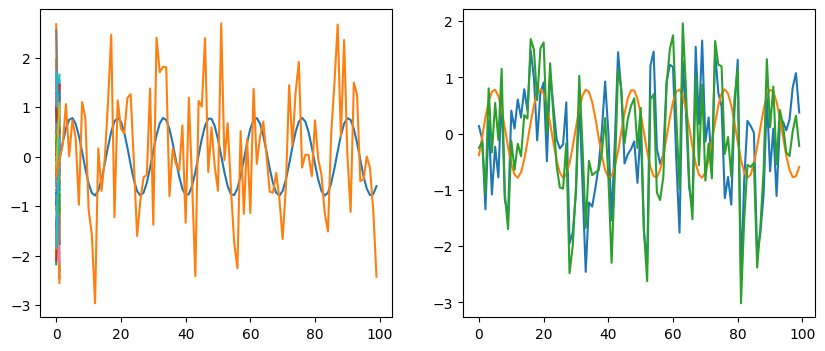

In [5]:
sample = simulator.sample()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(sample['noise'])
ax[0].plot(sample['signal'][0])
ax[0].plot(sample['data'][0])

ax[1].plot(sample['noise'][1])
ax[1].plot(sample['signal'][1])
ax[1].plot(sample['data'][1])

In [6]:
import swyft
import torch
from swyft.networks import OnlineStandardizingLayer, ResidualNetWithChannel


class Network(swyft.SwyftModule):
    def __init__(self, settings=None, sim=None):
        super().__init__()

        self.num_params = 1  # Number of parameters to infer
        self.npts = 100  # Number of frequency points
        self.channels = 2  # Number of input channels
        self.num_feat_param = self.channels

        # Standardization layers for non-log data
        self.nl_channel1_nolog = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_channel2_nolog = OnlineStandardizingLayer(shape=(self.npts,))

        # Residual networks for log and non-log data
        self.resnet_no_log = ResidualNetWithChannel(
            channels=self.channels,
            in_features=self.npts,
            out_features=self.num_params,
            hidden_features=64,
            num_blocks=2,
            dropout_probability=0.1,
            use_batch_norm=True,
        )

        # Log-ratio estimator for multi-dimensional inference
        self.log_ratio_estimator = swyft.LogRatioEstimator_1dim(
            num_features=1 * self.num_params * self.num_feat_param,
            num_params=1,
            varnames="xi",
        )

    def forward(self, A, B):
        

        # Non-log-transformed data
        no_log_data = A["data"]
        #print(f"no_log_data shape: {no_log_data.shape}")

        # Normalize each channel independently
        norm_channel1_nolog = self.nl_channel1_nolog(no_log_data[:, 0, :])
        norm_channel2_nolog = self.nl_channel2_nolog(no_log_data[:, 1, :])
        #print(f"norm_channel1_nolog shape: {norm_channel1_nolog.shape}")
        #print(f"norm_channel2_nolog shape: {norm_channel2_nolog.shape}")

        # Stack normalized channels
        no_log_full_data = torch.stack([norm_channel1_nolog, norm_channel2_nolog], dim=1)
        #print(f"no_log_full_data shape: {no_log_full_data.shape}")

        # Process with residual networks
        no_log_compression = self.resnet_no_log(no_log_full_data)
        #print(f"no_log_compression shape: {no_log_compression.shape}")

        # Flatten and combine outputs
        s_no_log = no_log_compression.reshape(-1, self.num_params * self.num_feat_param)
        #print(f"s_no_log shape: {s_no_log.shape}")

        # Pass to log-ratio estimator
        log_ratio = self.log_ratio_estimator(s_no_log, B["xi"])
        #print(f"log_ratio shape: {log_ratio.shape}")

        return log_ratio



In [54]:
import swyft
import torch
from swyft.networks import OnlineStandardizingLayer, ResidualNetWithChannel


class Network_Test(swyft.SwyftModule):
    def __init__(self, settings=None, sim=None):
        super().__init__()

        self.num_params = 1  # Number of parameters to infer
        self.npts = 100  # Number of frequency points
        self.channels = 2  # Number of input channels
        self.num_feat_param = self.channels

        # Standardization layers for non-log data
        self.nl_channel1_nolog = OnlineStandardizingLayer(shape=(self.npts,))
        self.nl_channel2_nolog = OnlineStandardizingLayer(shape=(self.npts,))

        # Residual networks for log and non-log data
        self.resnet_no_log = ResidualNetWithChannel(
            channels=self.channels,
            in_features=self.npts,
            out_features=50,
            hidden_features=64,
            num_blocks=2,
            dropout_probability=0.1,
            use_batch_norm=True,
        )

        # Log-ratio estimator for multi-dimensional inference
        self.log_ratio_estimator = swyft.LogRatioEstimator_1dim(
            num_features=1 * 50 * self.num_feat_param,
            num_params=1,
            varnames="xi",
        )

    def forward(self, A, B):
        

        # Non-log-transformed data
        no_log_data = A["data"]
        #print(f"no_log_data shape: {no_log_data.shape}")

        # Normalize each channel independently
        norm_channel1_nolog = self.nl_channel1_nolog(no_log_data[:, 0, :])
        norm_channel2_nolog = self.nl_channel2_nolog(no_log_data[:, 1, :])
        #print(f"norm_channel1_nolog shape: {norm_channel1_nolog.shape}")
        #print(f"norm_channel2_nolog shape: {norm_channel2_nolog.shape}")

        # Stack normalized channels
        no_log_full_data = torch.stack([norm_channel1_nolog, norm_channel2_nolog], dim=1)
        #print(f"no_log_full_data shape: {no_log_full_data.shape}")

        # Process with residual networks
        no_log_compression = self.resnet_no_log(no_log_full_data)
        #print(f"no_log_compression shape: {no_log_compression.shape}")

        # Flatten and combine outputs
        s_no_log = no_log_compression.reshape(-1, 50 * self.num_feat_param)
        #print(f"s_no_log shape: {s_no_log.shape}")

        # Pass to log-ratio estimator
        log_ratio = self.log_ratio_estimator(s_no_log, B["xi"])
        #print(f"log_ratio shape: {log_ratio.shape}")

        return log_ratio

In [56]:
dm = data.OnTheFlyDataModule(simulator, Nsims_per_epoch=10000, batch_size=128)
trainer = swyft.SwyftTrainer(accelerator='cuda', max_epochs=100, enable_progress_bar=True)
network_test = Network_Test()
trainer.fit(network_test, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 8819.98it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                     | Params
-----------------------------------------------------------------
0 | nl_channel1_nolog   | OnlineStandardizingLayer | 0     
1 | nl_channel2_nolog   | OnlineStandardizingLayer | 0     
2 | resnet_no_log       | ResidualNetWithChannel   | 53.7 K
3 | log_ratio_estimator | LogRatioEstimator_1dim   | 23.7 K
-----------------------------------------------------------------
77.5 K    Trainable params
0         Non-trainable params
77.5 K    Total params
0.310     Total estimated model params size (MB)


/home/zaldivar/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/zaldivar/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/71 [00:00<?, ?it/s] 

100%|██████████| 1/1 [00:00<00:00, 1090.00it/s]


Epoch 0:   1%|▏         | 1/71 [00:00<00:43,  1.62it/s, loss=4.46e-05, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 868.93it/s]


Epoch 0:   3%|▎         | 2/71 [00:01<00:42,  1.61it/s, loss=0.000163, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 1034.86it/s]


Epoch 0:   4%|▍         | 3/71 [00:01<00:43,  1.58it/s, loss=0.000207, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 890.13it/s]


Epoch 0:   6%|▌         | 4/71 [00:02<00:43,  1.53it/s, loss=0.000253, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 951.31it/s]


Epoch 0:   7%|▋         | 5/71 [00:03<00:42,  1.54it/s, loss=0.000164, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 855.81it/s]


Epoch 0:   8%|▊         | 6/71 [00:03<00:42,  1.53it/s, loss=4.25e-05, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 817.60it/s]


Epoch 0:  10%|▉         | 7/71 [00:04<00:42,  1.52it/s, loss=0.00021, v_num=2] 

100%|██████████| 1/1 [00:00<00:00, 840.54it/s]


Epoch 0:  11%|█▏        | 8/71 [00:05<00:41,  1.51it/s, loss=0.000295, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 637.04it/s]


Epoch 0:  13%|█▎        | 9/71 [00:06<00:41,  1.50it/s, loss=0.000197, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 1119.38it/s]


Epoch 0:  14%|█▍        | 10/71 [00:06<00:40,  1.50it/s, loss=0.000154, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 1774.99it/s]


Epoch 0:  15%|█▌        | 11/71 [00:07<00:39,  1.50it/s, loss=-0.000173, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 1151.96it/s]


Epoch 0:  17%|█▋        | 12/71 [00:08<00:39,  1.50it/s, loss=-0.000229, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 720.05it/s]


Epoch 0:  18%|█▊        | 13/71 [00:08<00:38,  1.50it/s, loss=-0.000521, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 1031.56it/s]


Epoch 0:  20%|█▉        | 14/71 [00:09<00:38,  1.49it/s, loss=-0.000611, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 903.17it/s]


Epoch 0:  21%|██        | 15/71 [00:09<00:37,  1.50it/s, loss=-0.000834, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 2186.81it/s]


Epoch 0:  23%|██▎       | 16/71 [00:10<00:36,  1.51it/s, loss=-0.00128, v_num=2] 

100%|██████████| 1/1 [00:00<00:00, 745.39it/s]


Epoch 0:  24%|██▍       | 17/71 [00:11<00:35,  1.50it/s, loss=-0.00157, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 1161.21it/s]


Epoch 0:  25%|██▌       | 18/71 [00:11<00:35,  1.50it/s, loss=-0.00209, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 902.00it/s]


Epoch 0:  27%|██▋       | 19/71 [00:12<00:34,  1.51it/s, loss=-0.00252, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 1197.69it/s]


Epoch 0:  28%|██▊       | 20/71 [00:13<00:33,  1.50it/s, loss=-0.00299, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 785.30it/s]


Epoch 0:  30%|██▉       | 21/71 [00:13<00:33,  1.51it/s, loss=-0.004, v_num=2]  

100%|██████████| 1/1 [00:00<00:00, 1092.27it/s]


Epoch 0:  31%|███       | 22/71 [00:14<00:32,  1.51it/s, loss=-0.00483, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 922.64it/s]


Epoch 0:  32%|███▏      | 23/71 [00:15<00:31,  1.51it/s, loss=-0.00515, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 998.88it/s]


Epoch 0:  34%|███▍      | 24/71 [00:15<00:31,  1.50it/s, loss=-0.00543, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 1085.76it/s]


Epoch 0:  35%|███▌      | 25/71 [00:16<00:30,  1.51it/s, loss=-0.00847, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 888.44it/s]


Epoch 0:  37%|███▋      | 26/71 [00:17<00:29,  1.51it/s, loss=-0.0103, v_num=2] 

100%|██████████| 1/1 [00:00<00:00, 1005.35it/s]


Epoch 0:  38%|███▊      | 27/71 [00:17<00:29,  1.51it/s, loss=-0.00936, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 810.65it/s]


Epoch 0:  39%|███▉      | 28/71 [00:18<00:28,  1.50it/s, loss=-0.00872, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 1008.49it/s]


Epoch 0:  41%|████      | 29/71 [00:19<00:27,  1.50it/s, loss=-0.00823, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 951.74it/s]


Epoch 0:  42%|████▏     | 30/71 [00:19<00:27,  1.50it/s, loss=-0.0097, v_num=2] 

100%|██████████| 1/1 [00:00<00:00, 780.92it/s]


Epoch 0:  44%|████▎     | 31/71 [00:20<00:26,  1.50it/s, loss=-0.0106, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 940.64it/s]


Epoch 0:  45%|████▌     | 32/71 [00:21<00:26,  1.50it/s, loss=-0.0109, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 917.59it/s]


Epoch 0:  46%|████▋     | 33/71 [00:22<00:25,  1.50it/s, loss=-0.011, v_num=2] 

100%|██████████| 1/1 [00:00<00:00, 765.10it/s]


Epoch 0:  48%|████▊     | 34/71 [00:22<00:24,  1.49it/s, loss=-0.0117, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 779.47it/s]


Epoch 0:  49%|████▉     | 35/71 [00:23<00:24,  1.49it/s, loss=-0.0126, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 976.56it/s]


Epoch 0:  51%|█████     | 36/71 [00:24<00:23,  1.49it/s, loss=-0.0136, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 936.44it/s]


Epoch 0:  52%|█████▏    | 37/71 [00:24<00:22,  1.48it/s, loss=-0.013, v_num=2] 

100%|██████████| 1/1 [00:00<00:00, 1894.45it/s]


Epoch 0:  54%|█████▎    | 38/71 [00:25<00:22,  1.48it/s, loss=-0.0134, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 993.20it/s]


Epoch 0:  55%|█████▍    | 39/71 [00:26<00:21,  1.48it/s, loss=-0.0127, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 637.72it/s]


Epoch 0:  56%|█████▋    | 40/71 [00:27<00:20,  1.48it/s, loss=-0.0142, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 786.92it/s]


Epoch 0:  58%|█████▊    | 41/71 [00:27<00:20,  1.48it/s, loss=-0.0145, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 905.12it/s]


Epoch 0:  59%|█████▉    | 42/71 [00:28<00:19,  1.48it/s, loss=-0.0135, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 1015.82it/s]


Epoch 0:  61%|██████    | 43/71 [00:28<00:18,  1.49it/s, loss=-0.014, v_num=2] 

100%|██████████| 1/1 [00:00<00:00, 1021.26it/s]


Epoch 0:  62%|██████▏   | 44/71 [00:29<00:18,  1.48it/s, loss=-0.0142, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 1168.33it/s]


Epoch 0:  63%|██████▎   | 45/71 [00:30<00:17,  1.49it/s, loss=-0.0118, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 889.94it/s]


Epoch 0:  65%|██████▍   | 46/71 [00:30<00:16,  1.49it/s, loss=-0.01, v_num=2]  

100%|██████████| 1/1 [00:00<00:00, 869.83it/s]


Epoch 0:  66%|██████▌   | 47/71 [00:31<00:16,  1.48it/s, loss=-0.0122, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 866.77it/s]


Epoch 0:  68%|██████▊   | 48/71 [00:32<00:15,  1.48it/s, loss=-0.0137, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 1134.82it/s]


Epoch 0:  69%|██████▉   | 49/71 [00:33<00:14,  1.48it/s, loss=-0.0154, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 973.83it/s]


Epoch 0:  70%|███████   | 50/71 [00:33<00:14,  1.49it/s, loss=-0.0156, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 748.31it/s]


Epoch 0:  72%|███████▏  | 51/71 [00:34<00:13,  1.49it/s, loss=-0.016, v_num=2] 

100%|██████████| 1/1 [00:00<00:00, 895.84it/s]


Epoch 0:  73%|███████▎  | 52/71 [00:34<00:12,  1.49it/s, loss=-0.0184, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 816.49it/s]


Epoch 0:  75%|███████▍  | 53/71 [00:35<00:12,  1.49it/s, loss=-0.0212, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 862.49it/s]


Epoch 0:  76%|███████▌  | 54/71 [00:36<00:11,  1.49it/s, loss=-0.0219, v_num=2]

100%|██████████| 1/1 [00:00<00:00, 788.85it/s]


Epoch 1:   0%|          | 0/71 [00:00<?, ?it/s, loss=-0.0228, v_num=2, val_loss=-.0269]         

100%|██████████| 1/1 [00:00<00:00, 1033.59it/s]


Epoch 1:   1%|▏         | 1/71 [00:00<00:49,  1.43it/s, loss=-0.0223, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1761.57it/s]


Epoch 1:   3%|▎         | 2/71 [00:01<00:47,  1.44it/s, loss=-0.0254, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1009.46it/s]


Epoch 1:   4%|▍         | 3/71 [00:02<00:46,  1.47it/s, loss=-0.0274, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1050.15it/s]


Epoch 1:   6%|▌         | 4/71 [00:02<00:43,  1.53it/s, loss=-0.0293, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 842.74it/s]


Epoch 1:   7%|▋         | 5/71 [00:03<00:44,  1.49it/s, loss=-0.029, v_num=2, val_loss=-.0269] 

100%|██████████| 1/1 [00:00<00:00, 962.88it/s]


Epoch 1:   8%|▊         | 6/71 [00:04<00:43,  1.48it/s, loss=-0.0297, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 911.01it/s]


Epoch 1:  10%|▉         | 7/71 [00:04<00:43,  1.47it/s, loss=-0.0335, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1149.75it/s]


Epoch 1:  11%|█▏        | 8/71 [00:05<00:42,  1.47it/s, loss=-0.0355, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1019.77it/s]


Epoch 1:  13%|█▎        | 9/71 [00:06<00:42,  1.47it/s, loss=-0.0365, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 876.55it/s]


Epoch 1:  14%|█▍        | 10/71 [00:06<00:41,  1.47it/s, loss=-0.0377, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1087.17it/s]


Epoch 1:  15%|█▌        | 11/71 [00:07<00:40,  1.47it/s, loss=-0.0401, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 841.89it/s]


Epoch 1:  17%|█▋        | 12/71 [00:08<00:40,  1.47it/s, loss=-0.0401, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 943.81it/s]


Epoch 1:  18%|█▊        | 13/71 [00:08<00:39,  1.46it/s, loss=-0.0388, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 907.27it/s]


Epoch 1:  20%|█▉        | 14/71 [00:09<00:38,  1.46it/s, loss=-0.0404, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1040.77it/s]


Epoch 1:  21%|██        | 15/71 [00:10<00:38,  1.46it/s, loss=-0.0384, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 796.03it/s]


Epoch 1:  23%|██▎       | 16/71 [00:10<00:37,  1.46it/s, loss=-0.0376, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 973.38it/s]


Epoch 1:  24%|██▍       | 17/71 [00:11<00:37,  1.46it/s, loss=-0.0353, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1016.80it/s]


Epoch 1:  25%|██▌       | 18/71 [00:12<00:36,  1.46it/s, loss=-0.0331, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1137.59it/s]


Epoch 1:  27%|██▋       | 19/71 [00:13<00:35,  1.45it/s, loss=-0.0329, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 756.68it/s]


Epoch 1:  28%|██▊       | 20/71 [00:13<00:35,  1.45it/s, loss=-0.0315, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1109.02it/s]


Epoch 1:  30%|██▉       | 21/71 [00:14<00:34,  1.45it/s, loss=-0.0316, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 988.52it/s]


Epoch 1:  31%|███       | 22/71 [00:15<00:33,  1.46it/s, loss=-0.0299, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1318.13it/s]


Epoch 1:  32%|███▏      | 23/71 [00:15<00:32,  1.46it/s, loss=-0.0265, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1090.85it/s]


Epoch 1:  34%|███▍      | 24/71 [00:16<00:32,  1.47it/s, loss=-0.0253, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1855.89it/s]


Epoch 1:  35%|███▌      | 25/71 [00:17<00:31,  1.47it/s, loss=-0.025, v_num=2, val_loss=-.0269] 

100%|██████████| 1/1 [00:00<00:00, 1229.64it/s]


Epoch 1:  37%|███▋      | 26/71 [00:17<00:30,  1.47it/s, loss=-0.0243, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1095.40it/s]


Epoch 1:  38%|███▊      | 27/71 [00:18<00:29,  1.47it/s, loss=-0.0223, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 758.88it/s]


Epoch 1:  39%|███▉      | 28/71 [00:19<00:29,  1.47it/s, loss=-0.0191, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1151.02it/s]


Epoch 1:  41%|████      | 29/71 [00:19<00:28,  1.47it/s, loss=-0.0201, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1730.32it/s]


Epoch 1:  42%|████▏     | 30/71 [00:20<00:27,  1.47it/s, loss=-0.0191, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 732.25it/s]


Epoch 1:  44%|████▎     | 31/71 [00:21<00:27,  1.47it/s, loss=-0.0196, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 3059.30it/s]


Epoch 1:  45%|████▌     | 32/71 [00:21<00:26,  1.47it/s, loss=-0.021, v_num=2, val_loss=-.0269] 

100%|██████████| 1/1 [00:00<00:00, 815.06it/s]


Epoch 1:  46%|████▋     | 33/71 [00:22<00:25,  1.47it/s, loss=-0.0213, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 907.27it/s]


Epoch 1:  48%|████▊     | 34/71 [00:23<00:25,  1.47it/s, loss=-0.0215, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1972.86it/s]


Epoch 1:  49%|████▉     | 35/71 [00:23<00:24,  1.48it/s, loss=-0.025, v_num=2, val_loss=-.0269] 

100%|██████████| 1/1 [00:00<00:00, 1028.52it/s]


Epoch 1:  51%|█████     | 36/71 [00:24<00:23,  1.48it/s, loss=-0.0253, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 746.58it/s]


Epoch 1:  52%|█████▏    | 37/71 [00:25<00:22,  1.48it/s, loss=-0.0256, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 693.50it/s]


Epoch 1:  54%|█████▎    | 38/71 [00:25<00:22,  1.48it/s, loss=-0.0263, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 759.84it/s]


Epoch 1:  55%|█████▍    | 39/71 [00:26<00:21,  1.48it/s, loss=-0.0278, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1007.04it/s]


Epoch 1:  56%|█████▋    | 40/71 [00:27<00:21,  1.48it/s, loss=-0.0308, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1177.51it/s]


Epoch 1:  58%|█████▊    | 41/71 [00:27<00:20,  1.48it/s, loss=-0.0307, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 898.91it/s]


Epoch 1:  59%|█████▉    | 42/71 [00:28<00:19,  1.47it/s, loss=-0.0292, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 769.31it/s]


Epoch 1:  61%|██████    | 43/71 [00:29<00:19,  1.47it/s, loss=-0.0316, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1615.68it/s]


Epoch 1:  62%|██████▏   | 44/71 [00:29<00:18,  1.47it/s, loss=-0.0344, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 876.92it/s]


Epoch 1:  63%|██████▎   | 45/71 [00:30<00:17,  1.47it/s, loss=-0.0341, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 711.99it/s]


Epoch 1:  65%|██████▍   | 46/71 [00:31<00:17,  1.47it/s, loss=-0.0332, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 981.81it/s]


Epoch 1:  66%|██████▌   | 47/71 [00:31<00:16,  1.47it/s, loss=-0.034, v_num=2, val_loss=-.0269] 

100%|██████████| 1/1 [00:00<00:00, 1246.08it/s]


Epoch 1:  68%|██████▊   | 48/71 [00:32<00:15,  1.47it/s, loss=-0.0371, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1107.55it/s]


Epoch 1:  69%|██████▉   | 49/71 [00:33<00:14,  1.47it/s, loss=-0.0346, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1745.44it/s]


Epoch 1:  70%|███████   | 50/71 [00:33<00:14,  1.47it/s, loss=-0.0353, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 791.83it/s]


Epoch 1:  72%|███████▏  | 51/71 [00:34<00:13,  1.47it/s, loss=-0.0313, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 1160.57it/s]


Epoch 1:  73%|███████▎  | 52/71 [00:35<00:12,  1.47it/s, loss=-0.0311, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 935.60it/s]


Epoch 1:  75%|███████▍  | 53/71 [00:36<00:12,  1.47it/s, loss=-0.0337, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 826.95it/s]


Epoch 1:  76%|███████▌  | 54/71 [00:36<00:11,  1.47it/s, loss=-0.0322, v_num=2, val_loss=-.0269]

100%|██████████| 1/1 [00:00<00:00, 654.24it/s]


Epoch 2:   0%|          | 0/71 [00:00<?, ?it/s, loss=-0.0301, v_num=2, val_loss=-.0346]         

100%|██████████| 1/1 [00:00<00:00, 1266.40it/s]


Epoch 2:   1%|▏         | 1/71 [00:00<00:46,  1.49it/s, loss=-0.0334, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 928.97it/s]


Epoch 2:   3%|▎         | 2/71 [00:01<00:47,  1.45it/s, loss=-0.0336, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 828.75it/s]


Epoch 2:   4%|▍         | 3/71 [00:02<00:46,  1.45it/s, loss=-0.0334, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 985.97it/s]


Epoch 2:   6%|▌         | 4/71 [00:02<00:46,  1.45it/s, loss=-0.0315, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1005.83it/s]


Epoch 2:   7%|▋         | 5/71 [00:03<00:44,  1.48it/s, loss=-0.0299, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1118.78it/s]


Epoch 2:   8%|▊         | 6/71 [00:04<00:43,  1.50it/s, loss=-0.0311, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1111.07it/s]


Epoch 2:  10%|▉         | 7/71 [00:04<00:42,  1.50it/s, loss=-0.0321, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 912.20it/s]


Epoch 2:  11%|█▏        | 8/71 [00:05<00:41,  1.51it/s, loss=-0.0317, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 881.34it/s]


Epoch 2:  13%|█▎        | 9/71 [00:05<00:41,  1.50it/s, loss=-0.0321, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 814.59it/s]


Epoch 2:  14%|█▍        | 10/71 [00:06<00:40,  1.50it/s, loss=-0.0333, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 925.08it/s]


Epoch 2:  15%|█▌        | 11/71 [00:07<00:40,  1.49it/s, loss=-0.032, v_num=2, val_loss=-.0346] 

100%|██████████| 1/1 [00:00<00:00, 1058.90it/s]


Epoch 2:  17%|█▋        | 12/71 [00:08<00:39,  1.48it/s, loss=-0.0324, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 728.05it/s]


Epoch 2:  18%|█▊        | 13/71 [00:08<00:38,  1.49it/s, loss=-0.0305, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 734.04it/s]


Epoch 2:  20%|█▉        | 14/71 [00:09<00:38,  1.49it/s, loss=-0.0337, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 780.34it/s]


Epoch 2:  21%|██        | 15/71 [00:10<00:37,  1.49it/s, loss=-0.0355, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1233.26it/s]


Epoch 2:  23%|██▎       | 16/71 [00:10<00:36,  1.50it/s, loss=-0.0353, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 846.14it/s]


Epoch 2:  24%|██▍       | 17/71 [00:11<00:35,  1.50it/s, loss=-0.0349, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1186.17it/s]


Epoch 2:  25%|██▌       | 18/71 [00:11<00:35,  1.51it/s, loss=-0.0353, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 990.62it/s]


Epoch 2:  27%|██▋       | 19/71 [00:12<00:34,  1.52it/s, loss=-0.0362, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1204.57it/s]


Epoch 2:  28%|██▊       | 20/71 [00:13<00:33,  1.52it/s, loss=-0.0372, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 2227.46it/s]


Epoch 2:  30%|██▉       | 21/71 [00:13<00:32,  1.52it/s, loss=-0.0357, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1070.79it/s]


Epoch 2:  31%|███       | 22/71 [00:14<00:32,  1.51it/s, loss=-0.0377, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1061.85it/s]


Epoch 2:  32%|███▏      | 23/71 [00:15<00:31,  1.52it/s, loss=-0.0392, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 886.75it/s]


Epoch 2:  34%|███▍      | 24/71 [00:15<00:31,  1.52it/s, loss=-0.0384, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 923.45it/s]


Epoch 2:  35%|███▌      | 25/71 [00:16<00:30,  1.52it/s, loss=-0.0394, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1111.07it/s]


Epoch 2:  37%|███▋      | 26/71 [00:17<00:29,  1.52it/s, loss=-0.0401, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 902.78it/s]


Epoch 2:  38%|███▊      | 27/71 [00:17<00:28,  1.52it/s, loss=-0.0412, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1064.00it/s]


Epoch 2:  39%|███▉      | 28/71 [00:18<00:28,  1.52it/s, loss=-0.0413, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 934.14it/s]


Epoch 2:  41%|████      | 29/71 [00:19<00:27,  1.52it/s, loss=-0.0387, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1176.85it/s]


Epoch 2:  42%|████▏     | 30/71 [00:19<00:26,  1.52it/s, loss=-0.0369, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1060.77it/s]


Epoch 2:  44%|████▎     | 31/71 [00:20<00:26,  1.53it/s, loss=-0.0375, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 823.54it/s]


Epoch 2:  45%|████▌     | 32/71 [00:20<00:25,  1.52it/s, loss=-0.0357, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1067.80it/s]


Epoch 2:  46%|████▋     | 33/71 [00:21<00:24,  1.52it/s, loss=-0.037, v_num=2, val_loss=-.0346] 

100%|██████████| 1/1 [00:00<00:00, 792.87it/s]


Epoch 2:  48%|████▊     | 34/71 [00:22<00:24,  1.52it/s, loss=-0.0363, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 865.70it/s]


Epoch 2:  49%|████▉     | 35/71 [00:22<00:23,  1.52it/s, loss=-0.0359, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 896.22it/s]


Epoch 2:  51%|█████     | 36/71 [00:23<00:22,  1.52it/s, loss=-0.0384, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 734.17it/s]


Epoch 2:  52%|█████▏    | 37/71 [00:24<00:22,  1.52it/s, loss=-0.0389, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1555.17it/s]


Epoch 2:  54%|█████▎    | 38/71 [00:24<00:21,  1.52it/s, loss=-0.0386, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1051.99it/s]


Epoch 2:  55%|█████▍    | 39/71 [00:25<00:20,  1.52it/s, loss=-0.0356, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 836.52it/s]


Epoch 2:  56%|█████▋    | 40/71 [00:26<00:20,  1.52it/s, loss=-0.0354, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 867.49it/s]


Epoch 2:  58%|█████▊    | 41/71 [00:26<00:19,  1.52it/s, loss=-0.0345, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 898.14it/s]


Epoch 2:  59%|█████▉    | 42/71 [00:27<00:19,  1.52it/s, loss=-0.0345, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1181.49it/s]


Epoch 2:  61%|██████    | 43/71 [00:28<00:18,  1.52it/s, loss=-0.0345, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1001.74it/s]


Epoch 2:  62%|██████▏   | 44/71 [00:28<00:17,  1.52it/s, loss=-0.0375, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 944.24it/s]


Epoch 2:  63%|██████▎   | 45/71 [00:29<00:17,  1.52it/s, loss=-0.0369, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 914.59it/s]


Epoch 2:  65%|██████▍   | 46/71 [00:30<00:16,  1.52it/s, loss=-0.036, v_num=2, val_loss=-.0346] 

100%|██████████| 1/1 [00:00<00:00, 748.58it/s]


Epoch 2:  66%|██████▌   | 47/71 [00:30<00:15,  1.52it/s, loss=-0.0376, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 980.21it/s]


Epoch 2:  68%|██████▊   | 48/71 [00:31<00:15,  1.52it/s, loss=-0.0367, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 936.65it/s]


Epoch 2:  69%|██████▉   | 49/71 [00:32<00:14,  1.52it/s, loss=-0.0377, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 1066.17it/s]


Epoch 2:  70%|███████   | 50/71 [00:32<00:13,  1.52it/s, loss=-0.0384, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 967.10it/s]


Epoch 2:  72%|███████▏  | 51/71 [00:33<00:13,  1.52it/s, loss=-0.0427, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 831.38it/s]


Epoch 2:  73%|███████▎  | 52/71 [00:34<00:12,  1.52it/s, loss=-0.0426, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 958.92it/s]


Epoch 2:  75%|███████▍  | 53/71 [00:34<00:11,  1.52it/s, loss=-0.043, v_num=2, val_loss=-.0346] 

100%|██████████| 1/1 [00:00<00:00, 1807.11it/s]


Epoch 2:  76%|███████▌  | 54/71 [00:35<00:11,  1.52it/s, loss=-0.0469, v_num=2, val_loss=-.0346]

100%|██████████| 1/1 [00:00<00:00, 2202.89it/s]


Epoch 3:   0%|          | 0/71 [00:00<?, ?it/s, loss=-0.0465, v_num=2, val_loss=-.0275]         

100%|██████████| 1/1 [00:00<00:00, 741.57it/s]


Epoch 3:   1%|▏         | 1/71 [00:00<00:43,  1.61it/s, loss=-0.0492, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1793.20it/s]


Epoch 3:   3%|▎         | 2/71 [00:01<00:44,  1.57it/s, loss=-0.0486, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1176.19it/s]


Epoch 3:   4%|▍         | 3/71 [00:01<00:43,  1.57it/s, loss=-0.0459, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1128.71it/s]


Epoch 3:   6%|▌         | 4/71 [00:02<00:43,  1.55it/s, loss=-0.0489, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 863.20it/s]


Epoch 3:   7%|▋         | 5/71 [00:03<00:43,  1.53it/s, loss=-0.0476, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1904.77it/s]


Epoch 3:   8%|▊         | 6/71 [00:03<00:42,  1.51it/s, loss=-0.0478, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 787.37it/s]


Epoch 3:  10%|▉         | 7/71 [00:04<00:42,  1.51it/s, loss=-0.0464, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 891.08it/s]


Epoch 3:  11%|█▏        | 8/71 [00:05<00:41,  1.53it/s, loss=-0.0473, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 882.08it/s]


Epoch 3:  13%|█▎        | 9/71 [00:05<00:40,  1.53it/s, loss=-0.047, v_num=2, val_loss=-.0275] 

100%|██████████| 1/1 [00:00<00:00, 945.94it/s]


Epoch 3:  14%|█▍        | 10/71 [00:06<00:40,  1.51it/s, loss=-0.046, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 831.05it/s]


Epoch 3:  15%|█▌        | 11/71 [00:07<00:39,  1.50it/s, loss=-0.0461, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 2496.61it/s]


Epoch 3:  17%|█▋        | 12/71 [00:07<00:39,  1.51it/s, loss=-0.0451, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 920.61it/s]


Epoch 3:  18%|█▊        | 13/71 [00:08<00:38,  1.51it/s, loss=-0.0476, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1113.14it/s]


Epoch 3:  20%|█▉        | 14/71 [00:09<00:37,  1.53it/s, loss=-0.047, v_num=2, val_loss=-.0275] 

100%|██████████| 1/1 [00:00<00:00, 1124.18it/s]


Epoch 3:  21%|██        | 15/71 [00:09<00:36,  1.55it/s, loss=-0.0489, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 762.74it/s]


Epoch 3:  23%|██▎       | 16/71 [00:10<00:35,  1.54it/s, loss=-0.0484, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 949.80it/s]


Epoch 3:  24%|██▍       | 17/71 [00:11<00:35,  1.53it/s, loss=-0.0496, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1076.01it/s]


Epoch 3:  25%|██▌       | 18/71 [00:11<00:34,  1.53it/s, loss=-0.0494, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1096.26it/s]


Epoch 3:  27%|██▋       | 19/71 [00:12<00:33,  1.54it/s, loss=-0.045, v_num=2, val_loss=-.0275] 

100%|██████████| 1/1 [00:00<00:00, 1092.55it/s]


Epoch 3:  28%|██▊       | 20/71 [00:13<00:33,  1.54it/s, loss=-0.0436, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1090.85it/s]


Epoch 3:  30%|██▉       | 21/71 [00:13<00:32,  1.54it/s, loss=-0.0395, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 892.22it/s]


Epoch 3:  31%|███       | 22/71 [00:14<00:32,  1.53it/s, loss=-0.041, v_num=2, val_loss=-.0275] 

100%|██████████| 1/1 [00:00<00:00, 952.17it/s]


Epoch 3:  32%|███▏      | 23/71 [00:15<00:31,  1.53it/s, loss=-0.0449, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1227.12it/s]


Epoch 3:  34%|███▍      | 24/71 [00:15<00:30,  1.53it/s, loss=-0.0456, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1097.41it/s]


Epoch 3:  35%|███▌      | 25/71 [00:16<00:30,  1.53it/s, loss=-0.0481, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 871.63it/s]


Epoch 3:  37%|███▋      | 26/71 [00:17<00:29,  1.53it/s, loss=-0.0482, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1106.97it/s]


Epoch 3:  38%|███▊      | 27/71 [00:17<00:28,  1.53it/s, loss=-0.0489, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 885.62it/s]


Epoch 3:  39%|███▉      | 28/71 [00:18<00:28,  1.53it/s, loss=-0.048, v_num=2, val_loss=-.0275] 

100%|██████████| 1/1 [00:00<00:00, 1015.57it/s]


Epoch 3:  41%|████      | 29/71 [00:19<00:27,  1.53it/s, loss=-0.049, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1075.19it/s]


Epoch 3:  42%|████▏     | 30/71 [00:19<00:26,  1.53it/s, loss=-0.0513, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 918.80it/s]


Epoch 3:  44%|████▎     | 31/71 [00:20<00:26,  1.53it/s, loss=-0.0499, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1072.71it/s]


Epoch 3:  45%|████▌     | 32/71 [00:20<00:25,  1.53it/s, loss=-0.0485, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1566.79it/s]


Epoch 3:  46%|████▋     | 33/71 [00:21<00:24,  1.53it/s, loss=-0.0473, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 854.59it/s]


Epoch 3:  48%|████▊     | 34/71 [00:22<00:24,  1.53it/s, loss=-0.0487, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 2032.12it/s]


Epoch 3:  49%|████▉     | 35/71 [00:22<00:23,  1.53it/s, loss=-0.0478, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 845.28it/s]


Epoch 3:  51%|█████     | 36/71 [00:23<00:22,  1.53it/s, loss=-0.0455, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1217.50it/s]


Epoch 3:  52%|█████▏    | 37/71 [00:24<00:22,  1.53it/s, loss=-0.0469, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 663.66it/s]


Epoch 3:  54%|█████▎    | 38/71 [00:24<00:21,  1.53it/s, loss=-0.0474, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 800.59it/s]


Epoch 3:  55%|█████▍    | 39/71 [00:25<00:20,  1.53it/s, loss=-0.0466, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1097.99it/s]


Epoch 3:  56%|█████▋    | 40/71 [00:26<00:20,  1.52it/s, loss=-0.0473, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 916.59it/s]


Epoch 3:  58%|█████▊    | 41/71 [00:26<00:19,  1.52it/s, loss=-0.0487, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 950.01it/s]


Epoch 3:  59%|█████▉    | 42/71 [00:27<00:19,  1.52it/s, loss=-0.0486, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1138.52it/s]


Epoch 3:  61%|██████    | 43/71 [00:28<00:18,  1.52it/s, loss=-0.0484, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1006.07it/s]


Epoch 3:  62%|██████▏   | 44/71 [00:28<00:17,  1.52it/s, loss=-0.0501, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1160.57it/s]


Epoch 3:  63%|██████▎   | 45/71 [00:29<00:17,  1.52it/s, loss=-0.0509, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 944.45it/s]


Epoch 3:  65%|██████▍   | 46/71 [00:30<00:16,  1.52it/s, loss=-0.0478, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 898.52it/s]


Epoch 3:  66%|██████▌   | 47/71 [00:30<00:15,  1.52it/s, loss=-0.0472, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 772.72it/s]


Epoch 3:  68%|██████▊   | 48/71 [00:31<00:15,  1.52it/s, loss=-0.0481, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1052.79it/s]


Epoch 3:  69%|██████▉   | 49/71 [00:32<00:14,  1.52it/s, loss=-0.0463, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 860.90it/s]


Epoch 3:  70%|███████   | 50/71 [00:32<00:13,  1.52it/s, loss=-0.0449, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1164.44it/s]


Epoch 3:  72%|███████▏  | 51/71 [00:33<00:13,  1.52it/s, loss=-0.0486, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 856.68it/s]


Epoch 3:  73%|███████▎  | 52/71 [00:34<00:12,  1.52it/s, loss=-0.0493, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 880.05it/s]


Epoch 3:  75%|███████▍  | 53/71 [00:34<00:11,  1.52it/s, loss=-0.0481, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 1318.96it/s]


Epoch 3:  76%|███████▌  | 54/71 [00:35<00:11,  1.52it/s, loss=-0.0484, v_num=2, val_loss=-.0275]

100%|██████████| 1/1 [00:00<00:00, 941.91it/s]


Epoch 4:   0%|          | 0/71 [00:00<?, ?it/s, loss=-0.0492, v_num=2, val_loss=-.0412]         

100%|██████████| 1/1 [00:00<00:00, 917.39it/s]


Epoch 4:   1%|▏         | 1/71 [00:00<00:42,  1.65it/s, loss=-0.0539, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1135.44it/s]


Epoch 4:   3%|▎         | 2/71 [00:01<00:43,  1.57it/s, loss=-0.0514, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 829.08it/s]


Epoch 4:   4%|▍         | 3/71 [00:01<00:44,  1.53it/s, loss=-0.049, v_num=2, val_loss=-.0412] 

100%|██████████| 1/1 [00:00<00:00, 900.84it/s]


Epoch 4:   6%|▌         | 4/71 [00:02<00:43,  1.53it/s, loss=-0.0525, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 977.69it/s]


Epoch 4:   7%|▋         | 5/71 [00:03<00:42,  1.55it/s, loss=-0.0541, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 875.09it/s]


Epoch 4:   8%|▊         | 6/71 [00:03<00:41,  1.57it/s, loss=-0.0571, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 771.58it/s]


Epoch 4:  10%|▉         | 7/71 [00:04<00:41,  1.56it/s, loss=-0.0558, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 830.23it/s]


Epoch 4:  11%|█▏        | 8/71 [00:05<00:40,  1.54it/s, loss=-0.0536, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1164.76it/s]


Epoch 4:  13%|█▎        | 9/71 [00:05<00:40,  1.53it/s, loss=-0.0499, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1034.10it/s]


Epoch 4:  14%|█▍        | 10/71 [00:06<00:39,  1.53it/s, loss=-0.0486, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1637.76it/s]


Epoch 4:  15%|█▌        | 11/71 [00:07<00:39,  1.52it/s, loss=-0.0522, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1151.33it/s]


Epoch 4:  17%|█▋        | 12/71 [00:07<00:38,  1.53it/s, loss=-0.055, v_num=2, val_loss=-.0412] 

100%|██████████| 1/1 [00:00<00:00, 1778.00it/s]


Epoch 4:  18%|█▊        | 13/71 [00:08<00:38,  1.52it/s, loss=-0.0511, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 805.36it/s]


Epoch 4:  20%|█▉        | 14/71 [00:09<00:37,  1.52it/s, loss=-0.0526, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 744.73it/s]


Epoch 4:  21%|██        | 15/71 [00:09<00:36,  1.52it/s, loss=-0.0528, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1031.05it/s]


Epoch 4:  23%|██▎       | 16/71 [00:10<00:36,  1.52it/s, loss=-0.0498, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1107.26it/s]


Epoch 4:  24%|██▍       | 17/71 [00:11<00:35,  1.52it/s, loss=-0.0505, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 854.76it/s]


Epoch 4:  25%|██▌       | 18/71 [00:11<00:34,  1.52it/s, loss=-0.0514, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 917.79it/s]


Epoch 4:  27%|██▋       | 19/71 [00:12<00:33,  1.54it/s, loss=-0.0497, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 843.75it/s]


Epoch 4:  28%|██▊       | 20/71 [00:13<00:33,  1.54it/s, loss=-0.0489, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 879.49it/s]


Epoch 4:  30%|██▉       | 21/71 [00:13<00:32,  1.53it/s, loss=-0.0473, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 2695.57it/s]


Epoch 4:  31%|███       | 22/71 [00:14<00:31,  1.53it/s, loss=-0.0508, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1119.38it/s]


Epoch 4:  32%|███▏      | 23/71 [00:15<00:31,  1.53it/s, loss=-0.0515, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 898.52it/s]


Epoch 4:  34%|███▍      | 24/71 [00:15<00:30,  1.53it/s, loss=-0.0508, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 784.13it/s]


Epoch 4:  35%|███▌      | 25/71 [00:16<00:30,  1.53it/s, loss=-0.0487, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1313.18it/s]


Epoch 4:  37%|███▋      | 26/71 [00:16<00:29,  1.53it/s, loss=-0.0456, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 2473.06it/s]


Epoch 4:  38%|███▊      | 27/71 [00:17<00:28,  1.53it/s, loss=-0.0449, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 920.61it/s]


Epoch 4:  39%|███▉      | 28/71 [00:18<00:28,  1.53it/s, loss=-0.0459, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 908.64it/s]


Epoch 4:  41%|████      | 29/71 [00:19<00:27,  1.53it/s, loss=-0.0449, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 965.10it/s]


Epoch 4:  42%|████▏     | 30/71 [00:19<00:26,  1.53it/s, loss=-0.0439, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 968.66it/s]


Epoch 4:  44%|████▎     | 31/71 [00:20<00:26,  1.52it/s, loss=-0.0424, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1056.23it/s]


Epoch 4:  45%|████▌     | 32/71 [00:20<00:25,  1.53it/s, loss=-0.041, v_num=2, val_loss=-.0412] 

100%|██████████| 1/1 [00:00<00:00, 792.13it/s]


Epoch 4:  46%|████▋     | 33/71 [00:21<00:24,  1.53it/s, loss=-0.0442, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 852.50it/s]


Epoch 4:  48%|████▊     | 34/71 [00:22<00:24,  1.53it/s, loss=-0.042, v_num=2, val_loss=-.0412] 

100%|██████████| 1/1 [00:00<00:00, 721.54it/s]


Epoch 4:  49%|████▉     | 35/71 [00:22<00:23,  1.53it/s, loss=-0.0407, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 778.74it/s]


Epoch 4:  51%|█████     | 36/71 [00:23<00:22,  1.53it/s, loss=-0.0412, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 2926.94it/s]


Epoch 4:  52%|█████▏    | 37/71 [00:24<00:22,  1.53it/s, loss=-0.0379, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 884.50it/s]


Epoch 4:  54%|█████▎    | 38/71 [00:24<00:21,  1.52it/s, loss=-0.0386, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 922.23it/s]


Epoch 4:  55%|█████▍    | 39/71 [00:25<00:21,  1.52it/s, loss=-0.0396, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1145.05it/s]


Epoch 4:  56%|█████▋    | 40/71 [00:26<00:20,  1.52it/s, loss=-0.0397, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1153.87it/s]


Epoch 4:  58%|█████▊    | 41/71 [00:26<00:19,  1.52it/s, loss=-0.038, v_num=2, val_loss=-.0412] 

100%|██████████| 1/1 [00:00<00:00, 1048.31it/s]


Epoch 4:  59%|█████▉    | 42/71 [00:27<00:19,  1.52it/s, loss=-0.0365, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 969.33it/s]


Epoch 4:  61%|██████    | 43/71 [00:28<00:18,  1.52it/s, loss=-0.0383, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1452.32it/s]


Epoch 4:  62%|██████▏   | 44/71 [00:28<00:17,  1.52it/s, loss=-0.0365, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1078.50it/s]


Epoch 4:  63%|██████▎   | 45/71 [00:29<00:17,  1.53it/s, loss=-0.038, v_num=2, val_loss=-.0412] 

100%|██████████| 1/1 [00:00<00:00, 942.54it/s]


Epoch 4:  65%|██████▍   | 46/71 [00:30<00:16,  1.53it/s, loss=-0.0376, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 955.64it/s]


Epoch 4:  66%|██████▌   | 47/71 [00:30<00:15,  1.53it/s, loss=-0.0378, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1098.56it/s]


Epoch 4:  68%|██████▊   | 48/71 [00:31<00:15,  1.53it/s, loss=-0.0385, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1822.03it/s]


Epoch 4:  69%|██████▉   | 49/71 [00:32<00:14,  1.53it/s, loss=-0.0393, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1037.68it/s]


Epoch 4:  70%|███████   | 50/71 [00:32<00:13,  1.53it/s, loss=-0.0371, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1011.89it/s]


Epoch 4:  72%|███████▏  | 51/71 [00:33<00:13,  1.53it/s, loss=-0.0371, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 922.43it/s]


Epoch 4:  73%|███████▎  | 52/71 [00:34<00:12,  1.53it/s, loss=-0.0355, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 813.01it/s]


Epoch 4:  75%|███████▍  | 53/71 [00:34<00:11,  1.53it/s, loss=-0.0345, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1068.61it/s]


Epoch 4:  76%|███████▌  | 54/71 [00:35<00:11,  1.53it/s, loss=-0.0376, v_num=2, val_loss=-.0412]

100%|██████████| 1/1 [00:00<00:00, 1756.41it/s]


Epoch 5:   0%|          | 0/71 [00:00<?, ?it/s, loss=-0.0381, v_num=2, val_loss=-.0518]         

100%|██████████| 1/1 [00:00<00:00, 833.69it/s]


Epoch 5:   1%|▏         | 1/71 [00:00<00:38,  1.80it/s, loss=-0.0361, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1159.61it/s]


Epoch 5:   3%|▎         | 2/71 [00:01<00:38,  1.80it/s, loss=-0.0373, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 967.32it/s]


Epoch 5:   4%|▍         | 3/71 [00:01<00:40,  1.68it/s, loss=-0.0371, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 2549.73it/s]


Epoch 5:   6%|▌         | 4/71 [00:02<00:40,  1.64it/s, loss=-0.0367, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1131.46it/s]


Epoch 5:   7%|▋         | 5/71 [00:03<00:40,  1.64it/s, loss=-0.0363, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 782.96it/s]


Epoch 5:   8%|▊         | 6/71 [00:03<00:39,  1.63it/s, loss=-0.036, v_num=2, val_loss=-.0518] 

100%|██████████| 1/1 [00:00<00:00, 1131.15it/s]


Epoch 5:  10%|▉         | 7/71 [00:04<00:39,  1.61it/s, loss=-0.0359, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1196.32it/s]


Epoch 5:  11%|█▏        | 8/71 [00:04<00:38,  1.62it/s, loss=-0.0362, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1721.80it/s]


Epoch 5:  13%|█▎        | 9/71 [00:05<00:38,  1.61it/s, loss=-0.0372, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 944.88it/s]


Epoch 5:  14%|█▍        | 10/71 [00:06<00:38,  1.59it/s, loss=-0.0367, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1015.08it/s]


Epoch 5:  15%|█▌        | 11/71 [00:06<00:37,  1.59it/s, loss=-0.0389, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 825.98it/s]


Epoch 5:  17%|█▋        | 12/71 [00:07<00:37,  1.57it/s, loss=-0.0402, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 2623.08it/s]


Epoch 5:  18%|█▊        | 13/71 [00:08<00:36,  1.58it/s, loss=-0.0396, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 842.74it/s]


Epoch 5:  20%|█▉        | 14/71 [00:08<00:35,  1.60it/s, loss=-0.0434, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 867.31it/s]


Epoch 5:  21%|██        | 15/71 [00:09<00:35,  1.60it/s, loss=-0.0465, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 916.39it/s]


Epoch 5:  23%|██▎       | 16/71 [00:10<00:34,  1.60it/s, loss=-0.0492, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1109.02it/s]


Epoch 5:  24%|██▍       | 17/71 [00:10<00:33,  1.60it/s, loss=-0.051, v_num=2, val_loss=-.0518] 

100%|██████████| 1/1 [00:00<00:00, 1055.97it/s]


Epoch 5:  25%|██▌       | 18/71 [00:11<00:33,  1.59it/s, loss=-0.0522, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 685.01it/s]


Epoch 5:  27%|██▋       | 19/71 [00:12<00:32,  1.58it/s, loss=-0.0489, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 944.03it/s]


Epoch 5:  28%|██▊       | 20/71 [00:12<00:32,  1.57it/s, loss=-0.0514, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 890.13it/s]


Epoch 5:  30%|██▉       | 21/71 [00:13<00:31,  1.57it/s, loss=-0.0518, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 2240.55it/s]


Epoch 5:  31%|███       | 22/71 [00:14<00:31,  1.56it/s, loss=-0.0535, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1108.43it/s]


Epoch 5:  32%|███▏      | 23/71 [00:14<00:30,  1.56it/s, loss=-0.0536, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1138.21it/s]


Epoch 5:  34%|███▍      | 24/71 [00:15<00:30,  1.56it/s, loss=-0.051, v_num=2, val_loss=-.0518] 

100%|██████████| 1/1 [00:00<00:00, 1237.99it/s]


Epoch 5:  35%|███▌      | 25/71 [00:15<00:29,  1.56it/s, loss=-0.0546, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1567.38it/s]


Epoch 5:  37%|███▋      | 26/71 [00:16<00:28,  1.57it/s, loss=-0.055, v_num=2, val_loss=-.0518] 

100%|██████████| 1/1 [00:00<00:00, 838.19it/s]


Epoch 5:  38%|███▊      | 27/71 [00:17<00:28,  1.56it/s, loss=-0.0542, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1183.49it/s]


Epoch 5:  39%|███▉      | 28/71 [00:17<00:27,  1.56it/s, loss=-0.0509, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1084.64it/s]


Epoch 5:  41%|████      | 29/71 [00:18<00:26,  1.56it/s, loss=-0.0513, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1933.75it/s]


Epoch 5:  42%|████▏     | 30/71 [00:19<00:26,  1.55it/s, loss=-0.0503, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1324.80it/s]


Epoch 5:  44%|████▎     | 31/71 [00:19<00:25,  1.55it/s, loss=-0.0494, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1288.97it/s]


Epoch 5:  45%|████▌     | 32/71 [00:20<00:25,  1.56it/s, loss=-0.0501, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 794.53it/s]


Epoch 5:  46%|████▋     | 33/71 [00:21<00:24,  1.56it/s, loss=-0.0498, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1127.20it/s]


Epoch 5:  48%|████▊     | 34/71 [00:21<00:23,  1.55it/s, loss=-0.0481, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1059.70it/s]


Epoch 5:  49%|████▉     | 35/71 [00:22<00:23,  1.56it/s, loss=-0.0481, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1032.32it/s]


Epoch 5:  51%|█████     | 36/71 [00:22<00:22,  1.57it/s, loss=-0.0465, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1240.18it/s]


Epoch 5:  52%|█████▏    | 37/71 [00:23<00:21,  1.56it/s, loss=-0.0469, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1060.77it/s]


Epoch 5:  54%|█████▎    | 38/71 [00:24<00:21,  1.56it/s, loss=-0.0444, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 788.70it/s]


Epoch 5:  55%|█████▍    | 39/71 [00:25<00:20,  1.56it/s, loss=-0.0473, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 828.26it/s]


Epoch 5:  56%|█████▋    | 40/71 [00:25<00:19,  1.56it/s, loss=-0.0449, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1172.25it/s]


Epoch 5:  58%|█████▊    | 41/71 [00:26<00:19,  1.56it/s, loss=-0.0503, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 991.56it/s]


Epoch 5:  59%|█████▉    | 42/71 [00:26<00:18,  1.56it/s, loss=-0.0492, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 811.28it/s]


Epoch 5:  61%|██████    | 43/71 [00:27<00:18,  1.55it/s, loss=-0.0499, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1304.60it/s]


Epoch 5:  62%|██████▏   | 44/71 [00:28<00:17,  1.56it/s, loss=-0.0543, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1270.23it/s]


Epoch 5:  63%|██████▎   | 45/71 [00:28<00:16,  1.56it/s, loss=-0.0511, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1015.82it/s]


Epoch 5:  65%|██████▍   | 46/71 [00:29<00:16,  1.56it/s, loss=-0.0485, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 828.75it/s]


Epoch 5:  66%|██████▌   | 47/71 [00:30<00:15,  1.56it/s, loss=-0.047, v_num=2, val_loss=-.0518] 

100%|██████████| 1/1 [00:00<00:00, 2327.58it/s]


Epoch 5:  68%|██████▊   | 48/71 [00:30<00:14,  1.56it/s, loss=-0.0492, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 845.46it/s]


Epoch 5:  69%|██████▉   | 49/71 [00:31<00:14,  1.55it/s, loss=-0.0499, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 978.83it/s]


Epoch 5:  70%|███████   | 50/71 [00:32<00:13,  1.55it/s, loss=-0.0501, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1107.26it/s]


Epoch 5:  72%|███████▏  | 51/71 [00:32<00:12,  1.55it/s, loss=-0.0498, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 769.31it/s]


Epoch 5:  73%|███████▎  | 52/71 [00:33<00:12,  1.55it/s, loss=-0.0493, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 875.82it/s]


Epoch 5:  75%|███████▍  | 53/71 [00:34<00:11,  1.55it/s, loss=-0.0513, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 1109.60it/s]


Epoch 5:  76%|███████▌  | 54/71 [00:34<00:10,  1.55it/s, loss=-0.0516, v_num=2, val_loss=-.0518]

100%|██████████| 1/1 [00:00<00:00, 921.02it/s]


Epoch 6:   0%|          | 0/71 [00:00<?, ?it/s, loss=-0.0535, v_num=2, val_loss=-.0538]         

100%|██████████| 1/1 [00:00<00:00, 801.82it/s]


Epoch 6:   1%|▏         | 1/71 [00:00<00:38,  1.81it/s, loss=-0.0549, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 706.47it/s]


Epoch 6:   3%|▎         | 2/71 [00:01<00:41,  1.64it/s, loss=-0.0536, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 833.36it/s]


Epoch 6:   4%|▍         | 3/71 [00:01<00:43,  1.56it/s, loss=-0.0565, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1492.10it/s]


Epoch 6:   6%|▌         | 4/71 [00:02<00:42,  1.56it/s, loss=-0.0551, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1125.99it/s]


Epoch 6:   7%|▋         | 5/71 [00:03<00:42,  1.56it/s, loss=-0.057, v_num=2, val_loss=-.0538] 

100%|██████████| 1/1 [00:00<00:00, 1040.25it/s]


Epoch 6:   8%|▊         | 6/71 [00:03<00:42,  1.54it/s, loss=-0.0539, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 753.96it/s]


Epoch 6:  10%|▉         | 7/71 [00:04<00:41,  1.53it/s, loss=-0.0534, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 839.20it/s]


Epoch 6:  11%|█▏        | 8/71 [00:05<00:41,  1.51it/s, loss=-0.0503, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1049.10it/s]


Epoch 6:  13%|█▎        | 9/71 [00:05<00:41,  1.50it/s, loss=-0.0504, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1247.56it/s]


Epoch 6:  14%|█▍        | 10/71 [00:06<00:40,  1.50it/s, loss=-0.0526, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1269.08it/s]


Epoch 6:  15%|█▌        | 11/71 [00:07<00:39,  1.51it/s, loss=-0.0544, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1062.12it/s]


Epoch 6:  17%|█▋        | 12/71 [00:07<00:38,  1.53it/s, loss=-0.056, v_num=2, val_loss=-.0538] 

100%|██████████| 1/1 [00:00<00:00, 829.73it/s]


Epoch 6:  18%|█▊        | 13/71 [00:08<00:37,  1.53it/s, loss=-0.0584, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 956.08it/s]


Epoch 6:  20%|█▉        | 14/71 [00:09<00:37,  1.53it/s, loss=-0.0598, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 979.52it/s]


Epoch 6:  21%|██        | 15/71 [00:09<00:36,  1.53it/s, loss=-0.0638, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1190.21it/s]


Epoch 6:  23%|██▎       | 16/71 [00:10<00:35,  1.53it/s, loss=-0.0624, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 778.74it/s]


Epoch 6:  24%|██▍       | 17/71 [00:11<00:35,  1.53it/s, loss=-0.0624, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1194.62it/s]


Epoch 6:  25%|██▌       | 18/71 [00:11<00:34,  1.53it/s, loss=-0.0617, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 887.12it/s]


Epoch 6:  27%|██▋       | 19/71 [00:12<00:34,  1.53it/s, loss=-0.0602, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1186.51it/s]


Epoch 6:  28%|██▊       | 20/71 [00:13<00:33,  1.53it/s, loss=-0.0607, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1109.60it/s]


Epoch 6:  30%|██▉       | 21/71 [00:13<00:32,  1.53it/s, loss=-0.0608, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1193.26it/s]


Epoch 6:  31%|███       | 22/71 [00:14<00:31,  1.54it/s, loss=-0.062, v_num=2, val_loss=-.0538] 

100%|██████████| 1/1 [00:00<00:00, 831.54it/s]


Epoch 6:  32%|███▏      | 23/71 [00:14<00:31,  1.54it/s, loss=-0.0636, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1051.99it/s]


Epoch 6:  34%|███▍      | 24/71 [00:15<00:30,  1.54it/s, loss=-0.0633, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 767.91it/s]


Epoch 6:  35%|███▌      | 25/71 [00:16<00:29,  1.54it/s, loss=-0.0637, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 895.64it/s]


Epoch 6:  37%|███▋      | 26/71 [00:16<00:29,  1.54it/s, loss=-0.0665, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 2511.56it/s]


Epoch 6:  38%|███▊      | 27/71 [00:17<00:28,  1.53it/s, loss=-0.0701, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 965.76it/s]


Epoch 6:  39%|███▉      | 28/71 [00:18<00:28,  1.53it/s, loss=-0.0702, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1062.66it/s]


Epoch 6:  41%|████      | 29/71 [00:18<00:27,  1.53it/s, loss=-0.0709, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 765.66it/s]


Epoch 6:  42%|████▏     | 30/71 [00:19<00:26,  1.54it/s, loss=-0.0665, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1820.44it/s]


Epoch 6:  44%|████▎     | 31/71 [00:20<00:25,  1.54it/s, loss=-0.0688, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 823.70it/s]


Epoch 6:  45%|████▌     | 32/71 [00:20<00:25,  1.54it/s, loss=-0.0687, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1010.43it/s]


Epoch 6:  46%|████▋     | 33/71 [00:21<00:24,  1.54it/s, loss=-0.0683, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1267.16it/s]


Epoch 6:  48%|████▊     | 34/71 [00:22<00:24,  1.54it/s, loss=-0.0639, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 786.63it/s]


Epoch 6:  49%|████▉     | 35/71 [00:22<00:23,  1.54it/s, loss=-0.0607, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 826.14it/s]


Epoch 6:  51%|█████     | 36/71 [00:23<00:22,  1.53it/s, loss=-0.0637, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 897.37it/s]


Epoch 6:  52%|█████▏    | 37/71 [00:24<00:22,  1.53it/s, loss=-0.0616, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 880.97it/s]


Epoch 6:  54%|█████▎    | 38/71 [00:24<00:21,  1.53it/s, loss=-0.0613, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 915.39it/s]


Epoch 6:  55%|█████▍    | 39/71 [00:25<00:20,  1.53it/s, loss=-0.0622, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1280.31it/s]


Epoch 6:  56%|█████▋    | 40/71 [00:26<00:20,  1.53it/s, loss=-0.059, v_num=2, val_loss=-.0538] 

100%|██████████| 1/1 [00:00<00:00, 632.15it/s]


Epoch 6:  58%|█████▊    | 41/71 [00:26<00:19,  1.53it/s, loss=-0.0583, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1040.51it/s]


Epoch 6:  59%|█████▉    | 42/71 [00:27<00:18,  1.53it/s, loss=-0.0572, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 916.99it/s]


Epoch 6:  61%|██████    | 43/71 [00:28<00:18,  1.53it/s, loss=-0.0555, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1421.32it/s]


Epoch 6:  62%|██████▏   | 44/71 [00:28<00:17,  1.53it/s, loss=-0.0578, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1262.20it/s]


Epoch 6:  63%|██████▎   | 45/71 [00:29<00:16,  1.54it/s, loss=-0.0562, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1122.37it/s]


Epoch 6:  65%|██████▍   | 46/71 [00:29<00:16,  1.55it/s, loss=-0.053, v_num=2, val_loss=-.0538] 

100%|██████████| 1/1 [00:00<00:00, 1230.72it/s]


Epoch 6:  66%|██████▌   | 47/71 [00:30<00:15,  1.55it/s, loss=-0.0504, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 926.10it/s]


Epoch 6:  68%|██████▊   | 48/71 [00:31<00:14,  1.55it/s, loss=-0.0535, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 805.36it/s]


Epoch 6:  69%|██████▉   | 49/71 [00:31<00:14,  1.54it/s, loss=-0.0527, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 1132.98it/s]


Epoch 6:  70%|███████   | 50/71 [00:32<00:13,  1.54it/s, loss=-0.056, v_num=2, val_loss=-.0538] 

100%|██████████| 1/1 [00:00<00:00, 950.44it/s]


Epoch 6:  72%|███████▏  | 51/71 [00:33<00:12,  1.54it/s, loss=-0.0577, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 2042.02it/s]


Epoch 6:  73%|███████▎  | 52/71 [00:33<00:12,  1.55it/s, loss=-0.0578, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 765.10it/s]


Epoch 6:  75%|███████▍  | 53/71 [00:34<00:11,  1.54it/s, loss=-0.0535, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 941.06it/s]


Epoch 6:  76%|███████▌  | 54/71 [00:35<00:11,  1.54it/s, loss=-0.0567, v_num=2, val_loss=-.0538]

100%|██████████| 1/1 [00:00<00:00, 800.44it/s]


Epoch 7:   0%|          | 0/71 [00:00<?, ?it/s, loss=-0.0575, v_num=2, val_loss=-.0646]         

100%|██████████| 1/1 [00:00<00:00, 1485.76it/s]


Epoch 7:   1%|▏         | 1/71 [00:00<00:46,  1.49it/s, loss=-0.0558, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 921.22it/s]


Epoch 7:   3%|▎         | 2/71 [00:01<00:47,  1.45it/s, loss=-0.0539, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1008.00it/s]


Epoch 7:   4%|▍         | 3/71 [00:01<00:45,  1.50it/s, loss=-0.051, v_num=2, val_loss=-.0646] 

100%|██████████| 1/1 [00:00<00:00, 2693.84it/s]


Epoch 7:   6%|▌         | 4/71 [00:02<00:44,  1.51it/s, loss=-0.0492, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 623.04it/s]


Epoch 7:   7%|▋         | 5/71 [00:03<00:43,  1.53it/s, loss=-0.0502, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1241.65it/s]


Epoch 7:   8%|▊         | 6/71 [00:03<00:41,  1.58it/s, loss=-0.048, v_num=2, val_loss=-.0646] 

100%|██████████| 1/1 [00:00<00:00, 741.31it/s]


Epoch 7:  10%|▉         | 7/71 [00:04<00:40,  1.57it/s, loss=-0.0487, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 936.44it/s]


Epoch 7:  11%|█▏        | 8/71 [00:05<00:40,  1.56it/s, loss=-0.0483, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 539.11it/s]


Epoch 7:  13%|█▎        | 9/71 [00:05<00:39,  1.55it/s, loss=-0.047, v_num=2, val_loss=-.0646] 

100%|██████████| 1/1 [00:00<00:00, 1020.26it/s]


Epoch 7:  14%|█▍        | 10/71 [00:06<00:39,  1.55it/s, loss=-0.0455, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1139.76it/s]


Epoch 7:  15%|█▌        | 11/71 [00:07<00:38,  1.54it/s, loss=-0.0451, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 832.53it/s]


Epoch 7:  17%|█▋        | 12/71 [00:07<00:37,  1.56it/s, loss=-0.0468, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 970.01it/s]


Epoch 7:  18%|█▊        | 13/71 [00:08<00:37,  1.56it/s, loss=-0.0458, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 857.56it/s]


Epoch 7:  20%|█▉        | 14/71 [00:09<00:36,  1.55it/s, loss=-0.0425, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 768.61it/s]


Epoch 7:  21%|██        | 15/71 [00:09<00:36,  1.55it/s, loss=-0.0432, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1401.37it/s]


Epoch 7:  23%|██▎       | 16/71 [00:10<00:35,  1.55it/s, loss=-0.041, v_num=2, val_loss=-.0646] 

100%|██████████| 1/1 [00:00<00:00, 943.81it/s]


Epoch 7:  24%|██▍       | 17/71 [00:11<00:34,  1.55it/s, loss=-0.0415, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 3618.90it/s]


Epoch 7:  25%|██▌       | 18/71 [00:11<00:33,  1.57it/s, loss=-0.0439, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 791.53it/s]


Epoch 7:  27%|██▋       | 19/71 [00:12<00:33,  1.57it/s, loss=-0.0433, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 826.95it/s]


Epoch 7:  28%|██▊       | 20/71 [00:12<00:32,  1.56it/s, loss=-0.0449, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1089.43it/s]


Epoch 7:  30%|██▉       | 21/71 [00:13<00:31,  1.57it/s, loss=-0.048, v_num=2, val_loss=-.0646] 

100%|██████████| 1/1 [00:00<00:00, 1080.45it/s]


Epoch 7:  31%|███       | 22/71 [00:14<00:31,  1.56it/s, loss=-0.0522, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1876.65it/s]


Epoch 7:  32%|███▏      | 23/71 [00:14<00:30,  1.56it/s, loss=-0.0538, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1191.56it/s]


Epoch 7:  34%|███▍      | 24/71 [00:15<00:29,  1.57it/s, loss=-0.053, v_num=2, val_loss=-.0646] 

100%|██████████| 1/1 [00:00<00:00, 1398.57it/s]


Epoch 7:  35%|███▌      | 25/71 [00:15<00:29,  1.58it/s, loss=-0.0533, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 955.86it/s]


Epoch 7:  37%|███▋      | 26/71 [00:16<00:28,  1.57it/s, loss=-0.0598, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 790.04it/s]


Epoch 7:  38%|███▊      | 27/71 [00:17<00:28,  1.56it/s, loss=-0.0593, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 914.99it/s]


Epoch 7:  39%|███▉      | 28/71 [00:17<00:27,  1.56it/s, loss=-0.0568, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 911.41it/s]


Epoch 7:  41%|████      | 29/71 [00:18<00:26,  1.56it/s, loss=-0.0573, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1777.25it/s]


Epoch 7:  42%|████▏     | 30/71 [00:19<00:26,  1.56it/s, loss=-0.0584, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1034.10it/s]


Epoch 7:  44%|████▎     | 31/71 [00:19<00:25,  1.56it/s, loss=-0.0594, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1857.53it/s]


Epoch 7:  45%|████▌     | 32/71 [00:20<00:24,  1.56it/s, loss=-0.0602, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1716.87it/s]


Epoch 7:  46%|████▋     | 33/71 [00:21<00:24,  1.56it/s, loss=-0.0589, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1100.87it/s]


Epoch 7:  48%|████▊     | 34/71 [00:21<00:23,  1.55it/s, loss=-0.0622, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1020.51it/s]


Epoch 7:  49%|████▉     | 35/71 [00:22<00:23,  1.55it/s, loss=-0.0627, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1038.97it/s]


Epoch 7:  51%|█████     | 36/71 [00:23<00:22,  1.55it/s, loss=-0.0602, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1041.80it/s]


Epoch 7:  52%|█████▏    | 37/71 [00:23<00:21,  1.56it/s, loss=-0.0623, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 867.49it/s]


Epoch 7:  54%|█████▎    | 38/71 [00:24<00:21,  1.56it/s, loss=-0.064, v_num=2, val_loss=-.0646] 

100%|██████████| 1/1 [00:00<00:00, 820.32it/s]


Epoch 7:  55%|█████▍    | 39/71 [00:25<00:20,  1.55it/s, loss=-0.0638, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 853.89it/s]


Epoch 7:  56%|█████▋    | 40/71 [00:25<00:19,  1.55it/s, loss=-0.06, v_num=2, val_loss=-.0646]  

100%|██████████| 1/1 [00:00<00:00, 914.99it/s]


Epoch 7:  58%|█████▊    | 41/71 [00:26<00:19,  1.55it/s, loss=-0.0553, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1171.92it/s]


Epoch 7:  59%|█████▉    | 42/71 [00:27<00:18,  1.55it/s, loss=-0.0592, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 909.43it/s]


Epoch 7:  61%|██████    | 43/71 [00:27<00:18,  1.55it/s, loss=-0.062, v_num=2, val_loss=-.0646] 

100%|██████████| 1/1 [00:00<00:00, 2316.02it/s]


Epoch 7:  62%|██████▏   | 44/71 [00:28<00:17,  1.56it/s, loss=-0.063, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1107.26it/s]


Epoch 7:  63%|██████▎   | 45/71 [00:28<00:16,  1.55it/s, loss=-0.0628, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 932.07it/s]


Epoch 7:  65%|██████▍   | 46/71 [00:29<00:16,  1.55it/s, loss=-0.0583, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 758.46it/s]


Epoch 7:  66%|██████▌   | 47/71 [00:30<00:15,  1.55it/s, loss=-0.0559, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1106.09it/s]


Epoch 7:  68%|██████▊   | 48/71 [00:30<00:14,  1.55it/s, loss=-0.0582, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1454.84it/s]


Epoch 7:  69%|██████▉   | 49/71 [00:31<00:14,  1.56it/s, loss=-0.0568, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 949.58it/s]


Epoch 7:  70%|███████   | 50/71 [00:32<00:13,  1.56it/s, loss=-0.0586, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 748.05it/s]


Epoch 7:  72%|███████▏  | 51/71 [00:32<00:12,  1.56it/s, loss=-0.0589, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 882.45it/s]


Epoch 7:  73%|███████▎  | 52/71 [00:33<00:12,  1.56it/s, loss=-0.057, v_num=2, val_loss=-.0646] 

100%|██████████| 1/1 [00:00<00:00, 888.25it/s]


Epoch 7:  75%|███████▍  | 53/71 [00:34<00:11,  1.56it/s, loss=-0.0592, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 1086.61it/s]


Epoch 7:  76%|███████▌  | 54/71 [00:34<00:10,  1.56it/s, loss=-0.0598, v_num=2, val_loss=-.0646]

100%|██████████| 1/1 [00:00<00:00, 789.29it/s]


Epoch 8:   0%|          | 0/71 [00:00<?, ?it/s, loss=-0.055, v_num=2, val_loss=-.0617]          

100%|██████████| 1/1 [00:00<00:00, 833.86it/s]


Epoch 8:   1%|▏         | 1/71 [00:00<00:47,  1.47it/s, loss=-0.0602, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1107.55it/s]


Epoch 8:   3%|▎         | 2/71 [00:01<00:46,  1.50it/s, loss=-0.0572, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 2866.92it/s]


Epoch 8:   4%|▍         | 3/71 [00:02<00:45,  1.50it/s, loss=-0.0554, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 765.52it/s]


Epoch 8:   6%|▌         | 4/71 [00:02<00:45,  1.49it/s, loss=-0.0538, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1006.31it/s]


Epoch 8:   7%|▋         | 5/71 [00:03<00:43,  1.51it/s, loss=-0.0552, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 891.08it/s]


Epoch 8:   8%|▊         | 6/71 [00:03<00:41,  1.55it/s, loss=-0.0568, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1761.57it/s]


Epoch 8:  10%|▉         | 7/71 [00:04<00:41,  1.55it/s, loss=-0.0524, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 769.03it/s]


Epoch 8:  11%|█▏        | 8/71 [00:05<00:40,  1.55it/s, loss=-0.0483, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 857.91it/s]


Epoch 8:  13%|█▎        | 9/71 [00:05<00:39,  1.56it/s, loss=-0.0475, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1400.90it/s]


Epoch 8:  14%|█▍        | 10/71 [00:06<00:38,  1.59it/s, loss=-0.0491, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 914.59it/s]


Epoch 8:  15%|█▌        | 11/71 [00:06<00:37,  1.59it/s, loss=-0.0503, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 886.75it/s]


Epoch 8:  17%|█▋        | 12/71 [00:07<00:37,  1.57it/s, loss=-0.051, v_num=2, val_loss=-.0617] 

100%|██████████| 1/1 [00:00<00:00, 964.87it/s]


Epoch 8:  18%|█▊        | 13/71 [00:08<00:37,  1.56it/s, loss=-0.0525, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 815.54it/s]


Epoch 8:  20%|█▉        | 14/71 [00:09<00:36,  1.55it/s, loss=-0.0513, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1157.05it/s]


Epoch 8:  21%|██        | 15/71 [00:09<00:36,  1.55it/s, loss=-0.0506, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1114.91it/s]


Epoch 8:  23%|██▎       | 16/71 [00:10<00:35,  1.57it/s, loss=-0.052, v_num=2, val_loss=-.0617] 

100%|██████████| 1/1 [00:00<00:00, 785.45it/s]


Epoch 8:  24%|██▍       | 17/71 [00:10<00:34,  1.56it/s, loss=-0.053, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 954.55it/s]


Epoch 8:  25%|██▌       | 18/71 [00:11<00:34,  1.56it/s, loss=-0.055, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 719.31it/s]


Epoch 8:  27%|██▋       | 19/71 [00:12<00:33,  1.56it/s, loss=-0.0522, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 2131.25it/s]


Epoch 8:  28%|██▊       | 20/71 [00:12<00:32,  1.56it/s, loss=-0.0536, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 820.64it/s]


Epoch 8:  30%|██▉       | 21/71 [00:13<00:31,  1.58it/s, loss=-0.0529, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 889.38it/s]


Epoch 8:  31%|███       | 22/71 [00:13<00:30,  1.58it/s, loss=-0.0547, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 803.04it/s]


Epoch 8:  32%|███▏      | 23/71 [00:14<00:30,  1.58it/s, loss=-0.0563, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1060.24it/s]


Epoch 8:  34%|███▍      | 24/71 [00:15<00:29,  1.58it/s, loss=-0.0576, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 820.80it/s]


Epoch 8:  35%|███▌      | 25/71 [00:15<00:29,  1.58it/s, loss=-0.055, v_num=2, val_loss=-.0617] 

100%|██████████| 1/1 [00:00<00:00, 1199.06it/s]


Epoch 8:  37%|███▋      | 26/71 [00:16<00:28,  1.58it/s, loss=-0.0554, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1314.42it/s]


Epoch 8:  38%|███▊      | 27/71 [00:17<00:27,  1.59it/s, loss=-0.0556, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 626.39it/s]


Epoch 8:  39%|███▉      | 28/71 [00:17<00:27,  1.58it/s, loss=-0.0568, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1124.78it/s]


Epoch 8:  41%|████      | 29/71 [00:18<00:26,  1.58it/s, loss=-0.0615, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 849.91it/s]


Epoch 8:  42%|████▏     | 30/71 [00:19<00:26,  1.57it/s, loss=-0.0594, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1064.54it/s]


Epoch 8:  44%|████▎     | 31/71 [00:19<00:25,  1.57it/s, loss=-0.0588, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1239.82it/s]


Epoch 8:  45%|████▌     | 32/71 [00:20<00:24,  1.58it/s, loss=-0.0623, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 815.22it/s]


Epoch 8:  46%|████▋     | 33/71 [00:20<00:23,  1.59it/s, loss=-0.0586, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1153.23it/s]


Epoch 8:  48%|████▊     | 34/71 [00:21<00:23,  1.58it/s, loss=-0.0619, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1440.35it/s]


Epoch 8:  49%|████▉     | 35/71 [00:22<00:22,  1.58it/s, loss=-0.0606, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 739.74it/s]


Epoch 8:  51%|█████     | 36/71 [00:22<00:22,  1.58it/s, loss=-0.0556, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 897.18it/s]


Epoch 8:  52%|█████▏    | 37/71 [00:23<00:21,  1.59it/s, loss=-0.0553, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 972.03it/s]


Epoch 8:  54%|█████▎    | 38/71 [00:23<00:20,  1.58it/s, loss=-0.053, v_num=2, val_loss=-.0617] 

100%|██████████| 1/1 [00:00<00:00, 1181.16it/s]


Epoch 8:  55%|█████▍    | 39/71 [00:24<00:20,  1.58it/s, loss=-0.0528, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1091.70it/s]


Epoch 8:  56%|█████▋    | 40/71 [00:25<00:19,  1.58it/s, loss=-0.0537, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1134.82it/s]


Epoch 8:  58%|█████▊    | 41/71 [00:25<00:18,  1.58it/s, loss=-0.0502, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 842.40it/s]


Epoch 8:  59%|█████▉    | 42/71 [00:26<00:18,  1.58it/s, loss=-0.0495, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 864.45it/s]


Epoch 8:  61%|██████    | 43/71 [00:27<00:17,  1.58it/s, loss=-0.0487, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 777.01it/s]


Epoch 8:  62%|██████▏   | 44/71 [00:27<00:17,  1.58it/s, loss=-0.0495, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 949.15it/s]


Epoch 8:  63%|██████▎   | 45/71 [00:28<00:16,  1.58it/s, loss=-0.0503, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1145.05it/s]


Epoch 8:  65%|██████▍   | 46/71 [00:29<00:15,  1.58it/s, loss=-0.0502, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 826.46it/s]


Epoch 8:  66%|██████▌   | 47/71 [00:29<00:15,  1.58it/s, loss=-0.0515, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 863.03it/s]


Epoch 8:  68%|██████▊   | 48/71 [00:30<00:14,  1.58it/s, loss=-0.0522, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 974.74it/s]


Epoch 8:  69%|██████▉   | 49/71 [00:30<00:13,  1.58it/s, loss=-0.0502, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1083.52it/s]


Epoch 8:  70%|███████   | 50/71 [00:31<00:13,  1.58it/s, loss=-0.0521, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1922.23it/s]


Epoch 8:  72%|███████▏  | 51/71 [00:32<00:12,  1.58it/s, loss=-0.0522, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1554.02it/s]


Epoch 8:  73%|███████▎  | 52/71 [00:32<00:12,  1.58it/s, loss=-0.0505, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 758.19it/s]


Epoch 8:  75%|███████▍  | 53/71 [00:33<00:11,  1.58it/s, loss=-0.0536, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 742.22it/s]


Epoch 8:  76%|███████▌  | 54/71 [00:34<00:10,  1.58it/s, loss=-0.0523, v_num=2, val_loss=-.0617]

100%|██████████| 1/1 [00:00<00:00, 1099.71it/s]


Epoch 9:   0%|          | 0/71 [00:00<?, ?it/s, loss=-0.0522, v_num=2, val_loss=-.0693]         

100%|██████████| 1/1 [00:00<00:00, 1005.11it/s]


Epoch 9:   1%|▏         | 1/71 [00:00<00:38,  1.83it/s, loss=-0.0571, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1337.47it/s]


Epoch 9:   3%|▎         | 2/71 [00:01<00:38,  1.80it/s, loss=-0.0548, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 2038.05it/s]


Epoch 9:   4%|▍         | 3/71 [00:01<00:39,  1.71it/s, loss=-0.0546, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1035.63it/s]


Epoch 9:   6%|▌         | 4/71 [00:02<00:40,  1.64it/s, loss=-0.054, v_num=2, val_loss=-.0693] 

100%|██████████| 1/1 [00:00<00:00, 1140.69it/s]


Epoch 9:   7%|▋         | 5/71 [00:03<00:41,  1.60it/s, loss=-0.0558, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1082.96it/s]


Epoch 9:   8%|▊         | 6/71 [00:03<00:39,  1.65it/s, loss=-0.0557, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 674.54it/s]


Epoch 9:  10%|▉         | 7/71 [00:04<00:39,  1.62it/s, loss=-0.056, v_num=2, val_loss=-.0693] 

100%|██████████| 1/1 [00:00<00:00, 912.80it/s]


Epoch 9:  11%|█▏        | 8/71 [00:04<00:38,  1.62it/s, loss=-0.057, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 851.64it/s]


Epoch 9:  13%|█▎        | 9/71 [00:05<00:38,  1.60it/s, loss=-0.054, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 911.81it/s]


Epoch 9:  14%|█▍        | 10/71 [00:06<00:38,  1.60it/s, loss=-0.0564, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1381.52it/s]


Epoch 9:  15%|█▌        | 11/71 [00:06<00:36,  1.63it/s, loss=-0.0585, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 866.23it/s]


Epoch 9:  17%|█▋        | 12/71 [00:07<00:36,  1.63it/s, loss=-0.0539, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 871.09it/s]


Epoch 9:  18%|█▊        | 13/71 [00:07<00:35,  1.63it/s, loss=-0.0535, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1004.14it/s]


Epoch 9:  20%|█▉        | 14/71 [00:08<00:35,  1.61it/s, loss=-0.053, v_num=2, val_loss=-.0693] 

100%|██████████| 1/1 [00:00<00:00, 1892.74it/s]


Epoch 9:  21%|██        | 15/71 [00:09<00:34,  1.62it/s, loss=-0.0525, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 919.60it/s]


Epoch 9:  23%|██▎       | 16/71 [00:09<00:33,  1.62it/s, loss=-0.0515, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1197.35it/s]


Epoch 9:  24%|██▍       | 17/71 [00:10<00:33,  1.62it/s, loss=-0.0528, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 961.56it/s]


Epoch 9:  25%|██▌       | 18/71 [00:11<00:32,  1.61it/s, loss=-0.0547, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 811.75it/s]


Epoch 9:  27%|██▋       | 19/71 [00:11<00:32,  1.60it/s, loss=-0.0551, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1175.20it/s]


Epoch 9:  28%|██▊       | 20/71 [00:12<00:31,  1.61it/s, loss=-0.0556, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1075.46it/s]


Epoch 9:  30%|██▉       | 21/71 [00:12<00:30,  1.63it/s, loss=-0.0526, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 923.45it/s]


Epoch 9:  31%|███       | 22/71 [00:13<00:30,  1.62it/s, loss=-0.0564, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 941.27it/s]


Epoch 9:  32%|███▏      | 23/71 [00:14<00:29,  1.62it/s, loss=-0.0586, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1011.16it/s]


Epoch 9:  34%|███▍      | 24/71 [00:14<00:29,  1.61it/s, loss=-0.0574, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1031.05it/s]


Epoch 9:  35%|███▌      | 25/71 [00:15<00:28,  1.61it/s, loss=-0.0572, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1183.16it/s]


Epoch 9:  37%|███▋      | 26/71 [00:16<00:27,  1.62it/s, loss=-0.0552, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1088.30it/s]


Epoch 9:  38%|███▊      | 27/71 [00:16<00:27,  1.62it/s, loss=-0.0559, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1201.12it/s]


Epoch 9:  39%|███▉      | 28/71 [00:17<00:26,  1.61it/s, loss=-0.0567, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1267.16it/s]


Epoch 9:  41%|████      | 29/71 [00:18<00:26,  1.61it/s, loss=-0.0578, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 953.03it/s]


Epoch 9:  42%|████▏     | 30/71 [00:18<00:25,  1.61it/s, loss=-0.0569, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1328.57it/s]


Epoch 9:  44%|████▎     | 31/71 [00:19<00:24,  1.62it/s, loss=-0.055, v_num=2, val_loss=-.0693] 

100%|██████████| 1/1 [00:00<00:00, 803.04it/s]


Epoch 9:  45%|████▌     | 32/71 [00:19<00:24,  1.62it/s, loss=-0.0595, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1034.35it/s]


Epoch 9:  46%|████▋     | 33/71 [00:20<00:23,  1.61it/s, loss=-0.06, v_num=2, val_loss=-.0693]  

100%|██████████| 1/1 [00:00<00:00, 888.81it/s]


Epoch 9:  48%|████▊     | 34/71 [00:21<00:23,  1.61it/s, loss=-0.0601, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1131.76it/s]


Epoch 9:  49%|████▉     | 35/71 [00:21<00:22,  1.61it/s, loss=-0.0595, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 939.58it/s]


Epoch 9:  51%|█████     | 36/71 [00:22<00:21,  1.61it/s, loss=-0.059, v_num=2, val_loss=-.0693] 

100%|██████████| 1/1 [00:00<00:00, 1944.51it/s]


Epoch 9:  52%|█████▏    | 37/71 [00:23<00:21,  1.61it/s, loss=-0.0599, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1102.60it/s]


Epoch 9:  54%|█████▎    | 38/71 [00:23<00:20,  1.61it/s, loss=-0.0568, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1044.14it/s]


Epoch 9:  55%|█████▍    | 39/71 [00:24<00:19,  1.61it/s, loss=-0.0559, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 955.86it/s]


Epoch 9:  56%|█████▋    | 40/71 [00:24<00:19,  1.61it/s, loss=-0.0551, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 942.33it/s]


Epoch 9:  58%|█████▊    | 41/71 [00:25<00:18,  1.61it/s, loss=-0.0586, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 960.45it/s]


Epoch 9:  59%|█████▉    | 42/71 [00:26<00:18,  1.61it/s, loss=-0.0563, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1024.25it/s]


Epoch 9:  61%|██████    | 43/71 [00:26<00:17,  1.60it/s, loss=-0.058, v_num=2, val_loss=-.0693] 

100%|██████████| 1/1 [00:00<00:00, 921.02it/s]


Epoch 9:  62%|██████▏   | 44/71 [00:27<00:16,  1.60it/s, loss=-0.0617, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1065.36it/s]


Epoch 9:  63%|██████▎   | 45/71 [00:28<00:16,  1.61it/s, loss=-0.0595, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 884.13it/s]


Epoch 9:  65%|██████▍   | 46/71 [00:28<00:15,  1.60it/s, loss=-0.0625, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 950.44it/s]


Epoch 9:  66%|██████▌   | 47/71 [00:29<00:14,  1.60it/s, loss=-0.0633, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 969.56it/s]


Epoch 9:  68%|██████▊   | 48/71 [00:29<00:14,  1.60it/s, loss=-0.0634, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 2039.04it/s]


Epoch 9:  69%|██████▉   | 49/71 [00:30<00:13,  1.60it/s, loss=-0.0654, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 1282.27it/s]


Epoch 9:  70%|███████   | 50/71 [00:31<00:13,  1.60it/s, loss=-0.068, v_num=2, val_loss=-.0693] 

100%|██████████| 1/1 [00:00<00:00, 1117.88it/s]


Epoch 9:  72%|███████▏  | 51/71 [00:31<00:12,  1.60it/s, loss=-0.0668, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 738.82it/s]


Epoch 9:  73%|███████▎  | 52/71 [00:32<00:11,  1.60it/s, loss=-0.0693, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 2186.81it/s]


Epoch 9:  75%|███████▍  | 53/71 [00:33<00:11,  1.60it/s, loss=-0.0675, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 655.97it/s]


Epoch 9:  76%|███████▌  | 54/71 [00:33<00:10,  1.60it/s, loss=-0.0689, v_num=2, val_loss=-.0693]

100%|██████████| 1/1 [00:00<00:00, 824.03it/s]


Epoch 10:   0%|          | 0/71 [00:00<?, ?it/s, loss=-0.0681, v_num=2, val_loss=-.0665]        

100%|██████████| 1/1 [00:00<00:00, 911.21it/s]


Epoch 10:   1%|▏         | 1/71 [00:00<00:39,  1.78it/s, loss=-0.0673, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 958.70it/s]


Epoch 10:   3%|▎         | 2/71 [00:01<00:41,  1.67it/s, loss=-0.066, v_num=2, val_loss=-.0665] 

100%|██████████| 1/1 [00:00<00:00, 1827.58it/s]


Epoch 10:   4%|▍         | 3/71 [00:01<00:41,  1.65it/s, loss=-0.0677, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1005.59it/s]


Epoch 10:   6%|▌         | 4/71 [00:02<00:41,  1.61it/s, loss=-0.068, v_num=2, val_loss=-.0665] 

100%|██████████| 1/1 [00:00<00:00, 1148.81it/s]


Epoch 10:   7%|▋         | 5/71 [00:03<00:41,  1.59it/s, loss=-0.0679, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 996.04it/s]


Epoch 10:   8%|▊         | 6/71 [00:03<00:39,  1.63it/s, loss=-0.066, v_num=2, val_loss=-.0665] 

100%|██████████| 1/1 [00:00<00:00, 1030.79it/s]


Epoch 10:  10%|▉         | 7/71 [00:04<00:39,  1.63it/s, loss=-0.0685, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 982.96it/s]


Epoch 10:  11%|█▏        | 8/71 [00:04<00:39,  1.60it/s, loss=-0.0632, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 816.01it/s]


Epoch 10:  13%|█▎        | 9/71 [00:05<00:38,  1.60it/s, loss=-0.0631, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 2654.62it/s]


Epoch 10:  14%|█▍        | 10/71 [00:06<00:38,  1.60it/s, loss=-0.0644, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1172.58it/s]


Epoch 10:  15%|█▌        | 11/71 [00:06<00:36,  1.63it/s, loss=-0.0651, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1900.45it/s]


Epoch 10:  17%|█▋        | 12/71 [00:07<00:36,  1.62it/s, loss=-0.0607, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 998.64it/s]


Epoch 10:  18%|█▊        | 13/71 [00:08<00:36,  1.60it/s, loss=-0.0586, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1161.21it/s]


Epoch 10:  20%|█▉        | 14/71 [00:08<00:35,  1.60it/s, loss=-0.0574, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1209.78it/s]


Epoch 10:  21%|██        | 15/71 [00:09<00:35,  1.60it/s, loss=-0.0541, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1070.79it/s]


Epoch 10:  23%|██▎       | 16/71 [00:09<00:33,  1.62it/s, loss=-0.0561, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 948.72it/s]


Epoch 10:  24%|██▍       | 17/71 [00:10<00:33,  1.62it/s, loss=-0.0534, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 671.63it/s]


Epoch 10:  25%|██▌       | 18/71 [00:11<00:32,  1.62it/s, loss=-0.0565, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1194.62it/s]


Epoch 10:  27%|██▋       | 19/71 [00:11<00:32,  1.62it/s, loss=-0.0524, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 902.19it/s]


Epoch 10:  28%|██▊       | 20/71 [00:12<00:31,  1.62it/s, loss=-0.0538, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1108.43it/s]


Epoch 10:  30%|██▉       | 21/71 [00:12<00:30,  1.63it/s, loss=-0.0544, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 793.32it/s]


Epoch 10:  31%|███       | 22/71 [00:13<00:30,  1.63it/s, loss=-0.0533, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 953.25it/s]


Epoch 10:  32%|███▏      | 23/71 [00:14<00:29,  1.63it/s, loss=-0.0505, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1191.23it/s]


Epoch 10:  34%|███▍      | 24/71 [00:14<00:28,  1.63it/s, loss=-0.0516, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1415.08it/s]


Epoch 10:  35%|███▌      | 25/71 [00:15<00:27,  1.64it/s, loss=-0.0531, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 784.13it/s]


Epoch 10:  37%|███▋      | 26/71 [00:15<00:27,  1.64it/s, loss=-0.0534, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1040.77it/s]


Epoch 10:  38%|███▊      | 27/71 [00:16<00:26,  1.64it/s, loss=-0.0527, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1843.65it/s]


Epoch 10:  39%|███▉      | 28/71 [00:17<00:26,  1.64it/s, loss=-0.0541, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 780.77it/s]


Epoch 10:  41%|████      | 29/71 [00:17<00:25,  1.64it/s, loss=-0.055, v_num=2, val_loss=-.0665] 

100%|██████████| 1/1 [00:00<00:00, 1417.47it/s]


Epoch 10:  42%|████▏     | 30/71 [00:18<00:24,  1.65it/s, loss=-0.0562, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1083.80it/s]


Epoch 10:  44%|████▎     | 31/71 [00:18<00:24,  1.64it/s, loss=-0.0556, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 807.68it/s]


Epoch 10:  45%|████▌     | 32/71 [00:19<00:23,  1.64it/s, loss=-0.0584, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1017.05it/s]


Epoch 10:  46%|████▋     | 33/71 [00:20<00:23,  1.63it/s, loss=-0.0586, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1025.00it/s]


Epoch 10:  48%|████▊     | 34/71 [00:20<00:22,  1.62it/s, loss=-0.0601, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1516.93it/s]


Epoch 10:  49%|████▉     | 35/71 [00:21<00:22,  1.62it/s, loss=-0.0616, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 861.96it/s]


Epoch 10:  51%|█████     | 36/71 [00:22<00:21,  1.62it/s, loss=-0.0606, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1323.54it/s]


Epoch 10:  52%|█████▏    | 37/71 [00:22<00:20,  1.62it/s, loss=-0.0609, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1132.37it/s]


Epoch 10:  54%|█████▎    | 38/71 [00:23<00:20,  1.62it/s, loss=-0.0629, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1804.78it/s]


Epoch 10:  55%|█████▍    | 39/71 [00:24<00:19,  1.62it/s, loss=-0.0612, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1095.12it/s]


Epoch 10:  56%|█████▋    | 40/71 [00:24<00:19,  1.62it/s, loss=-0.063, v_num=2, val_loss=-.0665] 

100%|██████████| 1/1 [00:00<00:00, 1996.34it/s]


Epoch 10:  58%|█████▊    | 41/71 [00:25<00:18,  1.62it/s, loss=-0.0674, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1006.07it/s]


Epoch 10:  59%|█████▉    | 42/71 [00:25<00:17,  1.63it/s, loss=-0.0702, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 990.39it/s]


Epoch 10:  61%|██████    | 43/71 [00:26<00:17,  1.62it/s, loss=-0.0711, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 776.58it/s]


Epoch 10:  62%|██████▏   | 44/71 [00:27<00:16,  1.62it/s, loss=-0.0704, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1111.37it/s]


Epoch 10:  63%|██████▎   | 45/71 [00:27<00:16,  1.62it/s, loss=-0.0708, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 951.52it/s]


Epoch 10:  65%|██████▍   | 46/71 [00:28<00:15,  1.63it/s, loss=-0.0651, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 791.53it/s]


Epoch 10:  66%|██████▌   | 47/71 [00:28<00:14,  1.63it/s, loss=-0.0645, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 761.77it/s]


Epoch 10:  68%|██████▊   | 48/71 [00:29<00:14,  1.63it/s, loss=-0.0666, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1534.13it/s]


Epoch 10:  69%|██████▉   | 49/71 [00:30<00:13,  1.63it/s, loss=-0.065, v_num=2, val_loss=-.0665] 

100%|██████████| 1/1 [00:00<00:00, 966.21it/s]


Epoch 10:  70%|███████   | 50/71 [00:30<00:12,  1.63it/s, loss=-0.0641, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 818.08it/s]


Epoch 10:  72%|███████▏  | 51/71 [00:31<00:12,  1.63it/s, loss=-0.0645, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1268.31it/s]


Epoch 10:  73%|███████▎  | 52/71 [00:32<00:11,  1.62it/s, loss=-0.0632, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 864.98it/s]


Epoch 10:  75%|███████▍  | 53/71 [00:32<00:11,  1.63it/s, loss=-0.0642, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 1148.81it/s]


Epoch 10:  76%|███████▌  | 54/71 [00:33<00:10,  1.63it/s, loss=-0.0611, v_num=2, val_loss=-.0665]

100%|██████████| 1/1 [00:00<00:00, 958.48it/s]


Epoch 11:   0%|          | 0/71 [00:00<?, ?it/s, loss=-0.0619, v_num=2, val_loss=-.0624]         

100%|██████████| 1/1 [00:00<00:00, 991.33it/s]


Epoch 11:   1%|▏         | 1/71 [00:00<00:45,  1.54it/s, loss=-0.0618, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 870.37it/s]


Epoch 11:   3%|▎         | 2/71 [00:01<00:47,  1.46it/s, loss=-0.062, v_num=2, val_loss=-.0624] 

100%|██████████| 1/1 [00:00<00:00, 1386.09it/s]


Epoch 11:   4%|▍         | 3/71 [00:02<00:45,  1.49it/s, loss=-0.0562, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 2548.18it/s]


Epoch 11:   6%|▌         | 4/71 [00:02<00:42,  1.58it/s, loss=-0.0603, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1066.17it/s]


Epoch 11:   7%|▋         | 5/71 [00:03<00:41,  1.58it/s, loss=-0.0589, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1083.52it/s]


Epoch 11:   8%|▊         | 6/71 [00:03<00:40,  1.59it/s, loss=-0.0539, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1950.84it/s]


Epoch 11:  10%|▉         | 7/71 [00:04<00:39,  1.63it/s, loss=-0.0516, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1817.29it/s]


Epoch 11:  11%|█▏        | 8/71 [00:04<00:38,  1.64it/s, loss=-0.0519, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1702.92it/s]


Epoch 11:  13%|█▎        | 9/71 [00:05<00:38,  1.63it/s, loss=-0.0505, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1552.30it/s]


Epoch 11:  14%|█▍        | 10/71 [00:06<00:37,  1.62it/s, loss=-0.0491, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 883.20it/s]


Epoch 11:  15%|█▌        | 11/71 [00:06<00:36,  1.64it/s, loss=-0.0562, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 824.03it/s]


Epoch 11:  17%|█▋        | 12/71 [00:07<00:36,  1.63it/s, loss=-0.0561, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1011.65it/s]


Epoch 11:  18%|█▊        | 13/71 [00:07<00:35,  1.64it/s, loss=-0.0567, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1045.44it/s]


Epoch 11:  20%|█▉        | 14/71 [00:08<00:34,  1.63it/s, loss=-0.0577, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 2601.93it/s]


Epoch 11:  21%|██        | 15/71 [00:09<00:33,  1.65it/s, loss=-0.0575, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1286.20it/s]


Epoch 11:  23%|██▎       | 16/71 [00:09<00:33,  1.65it/s, loss=-0.0565, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 676.94it/s]


Epoch 11:  24%|██▍       | 17/71 [00:10<00:32,  1.64it/s, loss=-0.0574, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1205.95it/s]


Epoch 11:  25%|██▌       | 18/71 [00:10<00:32,  1.64it/s, loss=-0.0533, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 983.65it/s]


Epoch 11:  27%|██▋       | 19/71 [00:11<00:31,  1.65it/s, loss=-0.0561, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1176.85it/s]


Epoch 11:  28%|██▊       | 20/71 [00:12<00:30,  1.65it/s, loss=-0.0551, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 884.50it/s]


Epoch 11:  30%|██▉       | 21/71 [00:12<00:30,  1.64it/s, loss=-0.0552, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1228.20it/s]


Epoch 11:  31%|███       | 22/71 [00:13<00:29,  1.63it/s, loss=-0.0546, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 785.74it/s]


Epoch 11:  32%|███▏      | 23/71 [00:14<00:29,  1.64it/s, loss=-0.0563, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1011.16it/s]


Epoch 11:  34%|███▍      | 24/71 [00:14<00:28,  1.64it/s, loss=-0.0592, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1416.99it/s]


Epoch 11:  35%|███▌      | 25/71 [00:15<00:28,  1.63it/s, loss=-0.0601, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 839.70it/s]


Epoch 11:  37%|███▋      | 26/71 [00:15<00:27,  1.63it/s, loss=-0.0595, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 834.19it/s]


Epoch 11:  38%|███▊      | 27/71 [00:16<00:27,  1.63it/s, loss=-0.0612, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 758.46it/s]


Epoch 11:  39%|███▉      | 28/71 [00:17<00:26,  1.62it/s, loss=-0.0612, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1123.88it/s]


Epoch 11:  41%|████      | 29/71 [00:17<00:25,  1.62it/s, loss=-0.0627, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 954.34it/s]


Epoch 11:  42%|████▏     | 30/71 [00:18<00:25,  1.62it/s, loss=-0.0651, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1056.50it/s]


Epoch 11:  44%|████▎     | 31/71 [00:19<00:24,  1.62it/s, loss=-0.0638, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1073.54it/s]


Epoch 11:  45%|████▌     | 32/71 [00:19<00:24,  1.61it/s, loss=-0.0647, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1052.26it/s]


Epoch 11:  46%|████▋     | 33/71 [00:20<00:23,  1.62it/s, loss=-0.0641, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 966.21it/s]


Epoch 11:  48%|████▊     | 34/71 [00:21<00:22,  1.61it/s, loss=-0.0636, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1669.71it/s]


Epoch 11:  49%|████▉     | 35/71 [00:21<00:22,  1.61it/s, loss=-0.0661, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1345.19it/s]


Epoch 11:  51%|█████     | 36/71 [00:22<00:21,  1.62it/s, loss=-0.0695, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 797.24it/s]


Epoch 11:  52%|█████▏    | 37/71 [00:22<00:21,  1.61it/s, loss=-0.0704, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1228.20it/s]


Epoch 11:  54%|█████▎    | 38/71 [00:23<00:20,  1.61it/s, loss=-0.0725, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1139.45it/s]


Epoch 11:  55%|█████▍    | 39/71 [00:24<00:19,  1.62it/s, loss=-0.0698, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 903.17it/s]


Epoch 11:  56%|█████▋    | 40/71 [00:24<00:19,  1.61it/s, loss=-0.0716, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1082.96it/s]


Epoch 11:  58%|█████▊    | 41/71 [00:25<00:18,  1.61it/s, loss=-0.0751, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1215.74it/s]


Epoch 11:  59%|█████▉    | 42/71 [00:26<00:17,  1.62it/s, loss=-0.0724, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1078.78it/s]


Epoch 11:  61%|██████    | 43/71 [00:26<00:17,  1.62it/s, loss=-0.0751, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1043.88it/s]


Epoch 11:  62%|██████▏   | 44/71 [00:27<00:16,  1.62it/s, loss=-0.0715, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1009.22it/s]


Epoch 11:  63%|██████▎   | 45/71 [00:27<00:16,  1.61it/s, loss=-0.068, v_num=2, val_loss=-.0624] 

100%|██████████| 1/1 [00:00<00:00, 1174.88it/s]


Epoch 11:  65%|██████▍   | 46/71 [00:28<00:15,  1.62it/s, loss=-0.0687, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 2216.86it/s]


Epoch 11:  66%|██████▌   | 47/71 [00:29<00:14,  1.62it/s, loss=-0.0642, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1012.38it/s]


Epoch 11:  68%|██████▊   | 48/71 [00:29<00:14,  1.61it/s, loss=-0.065, v_num=2, val_loss=-.0624] 

100%|██████████| 1/1 [00:00<00:00, 1152.60it/s]


Epoch 11:  69%|██████▉   | 49/71 [00:30<00:13,  1.61it/s, loss=-0.0642, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1047.79it/s]


Epoch 11:  70%|███████   | 50/71 [00:30<00:12,  1.62it/s, loss=-0.0638, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 980.66it/s]


Epoch 11:  72%|███████▏  | 51/71 [00:31<00:12,  1.62it/s, loss=-0.0646, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1142.86it/s]


Epoch 11:  73%|███████▎  | 52/71 [00:32<00:11,  1.62it/s, loss=-0.0639, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 1136.05it/s]


Epoch 11:  75%|███████▍  | 53/71 [00:32<00:11,  1.62it/s, loss=-0.064, v_num=2, val_loss=-.0624] 

100%|██████████| 1/1 [00:00<00:00, 974.74it/s]


Epoch 11:  76%|███████▌  | 54/71 [00:33<00:10,  1.62it/s, loss=-0.0633, v_num=2, val_loss=-.0624]

100%|██████████| 1/1 [00:00<00:00, 986.66it/s]


Epoch 12:   0%|          | 0/71 [00:00<?, ?it/s, loss=-0.0613, v_num=2, val_loss=-.062]          

100%|██████████| 1/1 [00:00<00:00, 1825.99it/s]


Epoch 12:   1%|▏         | 1/71 [00:00<00:44,  1.58it/s, loss=-0.0585, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 902.00it/s]


Epoch 12:   3%|▎         | 2/71 [00:01<00:42,  1.61it/s, loss=-0.0596, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 902.78it/s]


Epoch 12:   4%|▍         | 3/71 [00:01<00:41,  1.64it/s, loss=-0.0614, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1289.76it/s]


Epoch 12:   6%|▌         | 4/71 [00:02<00:41,  1.61it/s, loss=-0.0622, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 822.74it/s]


Epoch 12:   7%|▋         | 5/71 [00:03<00:41,  1.61it/s, loss=-0.0585, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1159.29it/s]


Epoch 12:   8%|▊         | 6/71 [00:03<00:40,  1.60it/s, loss=-0.0546, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1214.68it/s]


Epoch 12:  10%|▉         | 7/71 [00:04<00:39,  1.64it/s, loss=-0.0553, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1293.34it/s]


Epoch 12:  11%|█▏        | 8/71 [00:04<00:38,  1.65it/s, loss=-0.0537, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1109.02it/s]


Epoch 12:  13%|█▎        | 9/71 [00:05<00:37,  1.65it/s, loss=-0.0539, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1393.92it/s]


Epoch 12:  14%|█▍        | 10/71 [00:05<00:36,  1.67it/s, loss=-0.0546, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 746.05it/s]


Epoch 12:  15%|█▌        | 11/71 [00:06<00:36,  1.67it/s, loss=-0.0556, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1539.76it/s]


Epoch 12:  17%|█▋        | 12/71 [00:07<00:35,  1.66it/s, loss=-0.0586, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1014.10it/s]


Epoch 12:  18%|█▊        | 13/71 [00:07<00:35,  1.65it/s, loss=-0.0577, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1040.00it/s]


Epoch 12:  20%|█▉        | 14/71 [00:08<00:34,  1.66it/s, loss=-0.0586, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 997.93it/s]


Epoch 12:  21%|██        | 15/71 [00:09<00:33,  1.65it/s, loss=-0.0574, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1357.38it/s]


Epoch 12:  23%|██▎       | 16/71 [00:09<00:33,  1.67it/s, loss=-0.0554, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1212.23it/s]


Epoch 12:  24%|██▍       | 17/71 [00:10<00:32,  1.66it/s, loss=-0.0566, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 756.28it/s]


Epoch 12:  25%|██▌       | 18/71 [00:10<00:31,  1.66it/s, loss=-0.0547, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 949.58it/s]


Epoch 12:  27%|██▋       | 19/71 [00:11<00:31,  1.66it/s, loss=-0.0565, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 840.54it/s]


Epoch 12:  28%|██▊       | 20/71 [00:12<00:30,  1.66it/s, loss=-0.059, v_num=2, val_loss=-.062] 

100%|██████████| 1/1 [00:00<00:00, 991.09it/s]


Epoch 12:  30%|██▉       | 21/71 [00:12<00:30,  1.65it/s, loss=-0.0595, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1158.97it/s]


Epoch 12:  31%|███       | 22/71 [00:13<00:29,  1.65it/s, loss=-0.0594, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1299.35it/s]


Epoch 12:  32%|███▏      | 23/71 [00:13<00:28,  1.67it/s, loss=-0.0597, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 981.81it/s]


Epoch 12:  34%|███▍      | 24/71 [00:14<00:28,  1.66it/s, loss=-0.0597, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 763.99it/s]


Epoch 12:  35%|███▌      | 25/71 [00:15<00:27,  1.65it/s, loss=-0.0617, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1150.70it/s]


Epoch 12:  37%|███▋      | 26/71 [00:15<00:27,  1.66it/s, loss=-0.0624, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1065.36it/s]


Epoch 12:  38%|███▊      | 27/71 [00:16<00:26,  1.66it/s, loss=-0.0621, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1177.51it/s]


Epoch 12:  39%|███▉      | 28/71 [00:16<00:26,  1.65it/s, loss=-0.0606, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1291.75it/s]


Epoch 12:  41%|████      | 29/71 [00:17<00:25,  1.66it/s, loss=-0.0617, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 745.39it/s]


Epoch 12:  42%|████▏     | 30/71 [00:18<00:24,  1.66it/s, loss=-0.0642, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1161.54it/s]


Epoch 12:  44%|████▎     | 31/71 [00:18<00:24,  1.65it/s, loss=-0.0635, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 2005.88it/s]


Epoch 12:  45%|████▌     | 32/71 [00:19<00:23,  1.66it/s, loss=-0.0636, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1334.49it/s]


Epoch 12:  46%|████▋     | 33/71 [00:19<00:22,  1.66it/s, loss=-0.0649, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1299.75it/s]


Epoch 12:  48%|████▊     | 34/71 [00:20<00:22,  1.66it/s, loss=-0.0655, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 2214.52it/s]


Epoch 12:  49%|████▉     | 35/71 [00:20<00:21,  1.67it/s, loss=-0.0667, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 2071.26it/s]


Epoch 12:  51%|█████     | 36/71 [00:21<00:21,  1.67it/s, loss=-0.0695, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1156.41it/s]


Epoch 12:  52%|█████▏    | 37/71 [00:22<00:20,  1.67it/s, loss=-0.0638, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1285.02it/s]


Epoch 12:  54%|█████▎    | 38/71 [00:22<00:19,  1.67it/s, loss=-0.0627, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 775.86it/s]


Epoch 12:  55%|█████▍    | 39/71 [00:23<00:19,  1.67it/s, loss=-0.0625, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1027.76it/s]


Epoch 12:  56%|█████▋    | 40/71 [00:24<00:18,  1.66it/s, loss=-0.0583, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 775.43it/s]


Epoch 12:  58%|█████▊    | 41/71 [00:24<00:18,  1.67it/s, loss=-0.0595, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1179.17it/s]


Epoch 12:  59%|█████▉    | 42/71 [00:25<00:17,  1.66it/s, loss=-0.0576, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1104.05it/s]


Epoch 12:  61%|██████    | 43/71 [00:25<00:16,  1.66it/s, loss=-0.0582, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1268.31it/s]


Epoch 12:  62%|██████▏   | 44/71 [00:26<00:16,  1.66it/s, loss=-0.0595, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 875.27it/s]


Epoch 12:  63%|██████▎   | 45/71 [00:27<00:15,  1.66it/s, loss=-0.0607, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1216.09it/s]


Epoch 12:  65%|██████▍   | 46/71 [00:27<00:15,  1.66it/s, loss=-0.062, v_num=2, val_loss=-.062] 

100%|██████████| 1/1 [00:00<00:00, 970.01it/s]


Epoch 12:  66%|██████▌   | 47/71 [00:28<00:14,  1.66it/s, loss=-0.0643, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 770.16it/s]


Epoch 12:  68%|██████▊   | 48/71 [00:28<00:13,  1.66it/s, loss=-0.0664, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1082.68it/s]


Epoch 12:  69%|██████▉   | 49/71 [00:29<00:13,  1.66it/s, loss=-0.0647, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 2069.22it/s]


Epoch 12:  70%|███████   | 50/71 [00:30<00:12,  1.67it/s, loss=-0.064, v_num=2, val_loss=-.062] 

100%|██████████| 1/1 [00:00<00:00, 1017.54it/s]


Epoch 12:  72%|███████▏  | 51/71 [00:30<00:12,  1.67it/s, loss=-0.064, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1700.16it/s]


Epoch 12:  73%|███████▎  | 52/71 [00:31<00:11,  1.67it/s, loss=-0.0615, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1572.67it/s]


Epoch 12:  75%|███████▍  | 53/71 [00:31<00:10,  1.66it/s, loss=-0.0599, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1119.97it/s]


Epoch 12:  76%|███████▌  | 54/71 [00:32<00:10,  1.66it/s, loss=-0.0589, v_num=2, val_loss=-.062]

100%|██████████| 1/1 [00:00<00:00, 1123.57it/s]


Epoch 13:   0%|          | 0/71 [00:00<?, ?it/s, loss=-0.0548, v_num=2, val_loss=-.0643]         

100%|██████████| 1/1 [00:00<00:00, 1031.30it/s]


Epoch 13:   1%|▏         | 1/71 [00:00<00:43,  1.60it/s, loss=-0.0514, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 899.68it/s]


Epoch 13:   3%|▎         | 2/71 [00:01<00:44,  1.54it/s, loss=-0.0563, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1876.65it/s]


Epoch 13:   4%|▍         | 3/71 [00:02<00:45,  1.49it/s, loss=-0.0543, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1060.77it/s]


Epoch 13:   6%|▌         | 4/71 [00:02<00:43,  1.56it/s, loss=-0.0532, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 892.79it/s]


Epoch 13:   7%|▋         | 5/71 [00:03<00:42,  1.55it/s, loss=-0.0554, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1300.96it/s]


Epoch 13:   8%|▊         | 6/71 [00:03<00:42,  1.53it/s, loss=-0.0532, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1114.02it/s]


Epoch 13:  10%|▉         | 7/71 [00:04<00:40,  1.57it/s, loss=-0.0525, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 967.32it/s]


Epoch 13:  11%|█▏        | 8/71 [00:05<00:39,  1.59it/s, loss=-0.0509, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 828.75it/s]


Epoch 13:  13%|█▎        | 9/71 [00:05<00:39,  1.58it/s, loss=-0.049, v_num=2, val_loss=-.0643] 

100%|██████████| 1/1 [00:00<00:00, 1094.83it/s]


Epoch 13:  14%|█▍        | 10/71 [00:06<00:38,  1.58it/s, loss=-0.047, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 845.80it/s]


Epoch 13:  15%|█▌        | 11/71 [00:06<00:37,  1.59it/s, loss=-0.046, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 740.65it/s]


Epoch 13:  17%|█▋        | 12/71 [00:07<00:36,  1.60it/s, loss=-0.048, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 849.74it/s]


Epoch 13:  18%|█▊        | 13/71 [00:08<00:36,  1.61it/s, loss=-0.0476, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1164.44it/s]


Epoch 13:  20%|█▉        | 14/71 [00:08<00:35,  1.62it/s, loss=-0.0498, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1130.54it/s]


Epoch 13:  21%|██        | 15/71 [00:09<00:34,  1.64it/s, loss=-0.0487, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1281.49it/s]


Epoch 13:  23%|██▎       | 16/71 [00:09<00:33,  1.63it/s, loss=-0.0524, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 919.80it/s]


Epoch 13:  24%|██▍       | 17/71 [00:10<00:32,  1.64it/s, loss=-0.0554, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1724.63it/s]


Epoch 13:  25%|██▌       | 18/71 [00:11<00:32,  1.63it/s, loss=-0.0561, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 695.11it/s]


Epoch 13:  27%|██▋       | 19/71 [00:11<00:31,  1.63it/s, loss=-0.056, v_num=2, val_loss=-.0643] 

100%|██████████| 1/1 [00:00<00:00, 1072.44it/s]


Epoch 13:  28%|██▊       | 20/71 [00:12<00:31,  1.63it/s, loss=-0.0558, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1322.71it/s]


Epoch 13:  30%|██▉       | 21/71 [00:12<00:30,  1.64it/s, loss=-0.0557, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1145.98it/s]


Epoch 13:  31%|███       | 22/71 [00:13<00:29,  1.64it/s, loss=-0.0559, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1792.44it/s]


Epoch 13:  32%|███▏      | 23/71 [00:13<00:28,  1.66it/s, loss=-0.0585, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1113.73it/s]


Epoch 13:  34%|███▍      | 24/71 [00:14<00:28,  1.65it/s, loss=-0.0601, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1400.44it/s]


Epoch 13:  35%|███▌      | 25/71 [00:15<00:27,  1.65it/s, loss=-0.0579, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1071.07it/s]


Epoch 13:  37%|███▋      | 26/71 [00:15<00:27,  1.66it/s, loss=-0.0591, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 873.09it/s]


Epoch 13:  38%|███▊      | 27/71 [00:16<00:26,  1.66it/s, loss=-0.0619, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1052.26it/s]


Epoch 13:  39%|███▉      | 28/71 [00:16<00:25,  1.65it/s, loss=-0.0645, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1146.61it/s]


Epoch 13:  41%|████      | 29/71 [00:17<00:25,  1.66it/s, loss=-0.0673, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1872.46it/s]


Epoch 13:  42%|████▏     | 30/71 [00:18<00:24,  1.66it/s, loss=-0.069, v_num=2, val_loss=-.0643] 

100%|██████████| 1/1 [00:00<00:00, 1723.21it/s]


Epoch 13:  44%|████▎     | 31/71 [00:18<00:24,  1.66it/s, loss=-0.0683, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 2661.36it/s]


Epoch 13:  45%|████▌     | 32/71 [00:19<00:23,  1.67it/s, loss=-0.0655, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1063.46it/s]


Epoch 13:  46%|████▋     | 33/71 [00:19<00:22,  1.67it/s, loss=-0.067, v_num=2, val_loss=-.0643] 

100%|██████████| 1/1 [00:00<00:00, 2047.00it/s]


Epoch 13:  48%|████▊     | 34/71 [00:20<00:22,  1.67it/s, loss=-0.0675, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1158.97it/s]


Epoch 13:  49%|████▉     | 35/71 [00:20<00:21,  1.67it/s, loss=-0.0659, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1029.28it/s]


Epoch 13:  51%|█████     | 36/71 [00:21<00:20,  1.67it/s, loss=-0.0648, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1351.69it/s]


Epoch 13:  52%|█████▏    | 37/71 [00:22<00:20,  1.67it/s, loss=-0.0625, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1076.57it/s]


Epoch 13:  54%|█████▎    | 38/71 [00:22<00:19,  1.67it/s, loss=-0.0638, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1071.07it/s]


Epoch 13:  55%|█████▍    | 39/71 [00:23<00:19,  1.68it/s, loss=-0.066, v_num=2, val_loss=-.0643] 

100%|██████████| 1/1 [00:00<00:00, 2074.33it/s]


Epoch 13:  56%|█████▋    | 40/71 [00:23<00:18,  1.68it/s, loss=-0.0694, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1500.65it/s]


Epoch 13:  58%|█████▊    | 41/71 [00:24<00:17,  1.68it/s, loss=-0.0721, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1364.89it/s]


Epoch 13:  59%|█████▉    | 42/71 [00:24<00:17,  1.68it/s, loss=-0.0703, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 793.17it/s]


Epoch 13:  61%|██████    | 43/71 [00:25<00:16,  1.68it/s, loss=-0.0712, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1115.21it/s]


Epoch 13:  62%|██████▏   | 44/71 [00:26<00:16,  1.68it/s, loss=-0.0702, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1248.68it/s]


Epoch 13:  63%|██████▎   | 45/71 [00:26<00:15,  1.68it/s, loss=-0.073, v_num=2, val_loss=-.0643] 

100%|██████████| 1/1 [00:00<00:00, 1121.77it/s]


Epoch 13:  65%|██████▍   | 46/71 [00:27<00:14,  1.68it/s, loss=-0.0706, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1821.23it/s]


Epoch 13:  66%|██████▌   | 47/71 [00:28<00:14,  1.68it/s, loss=-0.0691, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1099.42it/s]


Epoch 13:  68%|██████▊   | 48/71 [00:28<00:13,  1.68it/s, loss=-0.0647, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 876.37it/s]


Epoch 13:  69%|██████▉   | 49/71 [00:29<00:13,  1.68it/s, loss=-0.0641, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1061.31it/s]


Epoch 13:  70%|███████   | 50/71 [00:29<00:12,  1.68it/s, loss=-0.061, v_num=2, val_loss=-.0643] 

100%|██████████| 1/1 [00:00<00:00, 807.06it/s]


Epoch 13:  72%|███████▏  | 51/71 [00:30<00:11,  1.68it/s, loss=-0.0605, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 769.46it/s]


Epoch 13:  73%|███████▎  | 52/71 [00:30<00:11,  1.68it/s, loss=-0.0616, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1158.65it/s]


Epoch 13:  75%|███████▍  | 53/71 [00:31<00:10,  1.68it/s, loss=-0.0599, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 931.24it/s]


Epoch 13:  76%|███████▌  | 54/71 [00:32<00:10,  1.68it/s, loss=-0.0593, v_num=2, val_loss=-.0643]

100%|██████████| 1/1 [00:00<00:00, 1167.68it/s]


Epoch 13: 100%|██████████| 71/71 [00:32<00:00,  2.17it/s, loss=-0.0648, v_num=2, val_loss=-.0607]
Reloading best model: /home/zaldivar/Documents/Androniki/phd/LIGO/LIGO_SGWB/notebooks/lightning_logs/version_0/checkpoints/lightning_logs/version_2/checkpoints/epoch=8-step=495.ckpt


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 10313.07it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.27it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9359.47it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.97it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11728.64it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.65it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 7916.96it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.20it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10076.33it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.98it/s] 

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11964.07it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.11it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9477.22it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.56it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9804.49it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.32it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11229.22it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.54it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11494.08it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.99it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10578.67it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.41it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11854.81it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.97it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 8791.98it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.04it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11571.52it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.31it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 8800.21it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.97it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10173.04it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.49it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10312.84it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.16it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11467.77it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.03it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9851.82it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.19it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11494.90it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.89it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9615.16it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.95it/s] 

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11886.53it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.52it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11817.54it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.61it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10111.24it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.61it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11809.29it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.75it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10623.17it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.54it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11821.70it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.07it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11806.49it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.31it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9513.48it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.49it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10644.98it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.15it/s] 

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10842.09it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.86it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11831.84it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.26it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11883.13it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.14it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9781.24it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.50it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11789.50it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.39it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9509.32it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.61it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10189.43it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.90it/s] 

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11786.02it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.48it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9281.40it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.17it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11677.15it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.45it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11575.79it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.52it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11552.93it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.89it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11690.01it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.77it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11425.04it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.91it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11863.03it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.64it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10198.42it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.31it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11830.30it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.87it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11805.36it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.13it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11516.83it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.54it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11768.23it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.48it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 8450.48it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.09it/s] 

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 8582.91it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.18it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11700.25it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.11it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11648.51it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.00it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11737.05it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.89it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11691.44it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.45it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11595.16it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.46it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10563.72it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.55it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11672.96it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.34it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11657.13it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.51it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9086.76it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.55it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11532.67it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.15it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11424.70it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.93it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10013.02it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.86it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11996.48it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.55it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 7806.28it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.22it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 8416.06it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.61it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11869.71it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.22it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11758.01it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.59it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11753.39it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.30it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10166.97it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.00it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11712.50it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.80it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11671.53it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.16it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11724.61it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.33it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11766.61it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.82it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11770.25it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.47it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11765.76it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.95it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10998.94it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.86it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11735.67it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 175.90it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11684.37it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.10it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11840.19it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.82it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11728.51it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.68it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 12097.34it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.42it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10385.28it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.94it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11536.98it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.41it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11805.83it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.21it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11996.89it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.46it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11818.37it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.92it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11364.86it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.84it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10263.65it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.08it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11599.77it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.68it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10072.49it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.93it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 7555.92it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.89it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9785.81it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.66it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9726.78it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 174.15it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11894.92it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.37it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11814.81it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.25it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11179.47it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 123.10it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11805.70it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.91it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11692.58it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.75it/s]


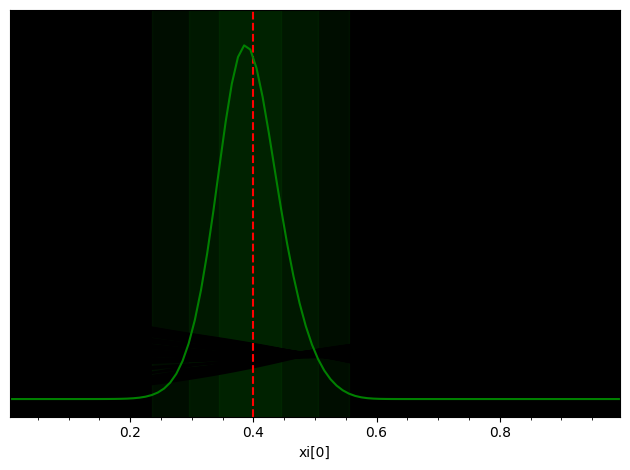

In [75]:
for idx in range(100):
    observation = simulator.sample(conditions={"xi": np.array([0.4])})
    prior_samples = swyft.Samples(
        xi=simulator.transform_samples(np.reshape(np.linspace(0.0, 1.0, 100), (-1, 1)))
    )
    predictions = trainer.infer(
        network_test, observation, prior_samples.get_dataloader(batch_size=2048)
    )
    if idx == 0:
        lrs_total = predictions
        swyft.plot_posterior(predictions, ["xi[0]"], smooth=2.0);
    else:
        lrs_total.logratios += predictions.logratios
        swyft.plot_posterior(predictions, ["xi[0]"], smooth=2.0, fig=plt.gcf());
plt.axvline(observation["xi"][0], color="red", linestyle="--")
swyft.plot_posterior(lrs_total, ["xi[0]"], smooth=2.0, color='green', fig=plt.gcf());

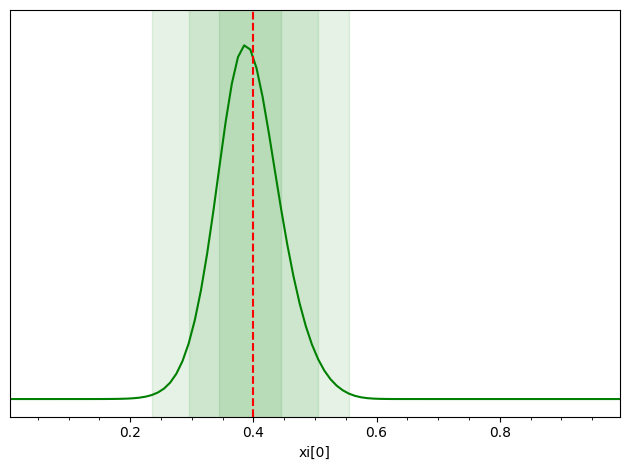

In [77]:
swyft.plot_posterior(lrs_total, ["xi[0]"], smooth=2.0, color='green');
plt.axvline(0.4, color='red', linestyle='--')

## Train network (skip)

In [ ]:
dm = data.OnTheFlyDataModule(simulator, Nsims_per_epoch=10000, batch_size=128)
trainer = swyft.SwyftTrainer(accelerator='cuda', max_epochs=100, enable_progress_bar=True)
network = Network()
trainer.fit(network, dm)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 7559.81it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.06it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11196.72it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 143.84it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11725.82it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.97it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10122.73it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.34it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11890.40it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.56it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10134.72it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.02it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11870.48it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.50it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9762.21it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.00it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11796.93it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.86it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11761.30it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.04it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11869.17it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.29it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11819.80it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.98it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11891.68it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.82it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11927.19it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.82it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11683.49it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.08it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10341.90it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.38it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11828.27it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.88it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9259.64it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 190.79it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11029.78it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 193.35it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9050.25it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.43it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 12015.76it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.61it/s] 

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9470.46it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.96it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11609.82it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.83it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11627.69it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.98it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9120.77it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.00it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11040.05it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.56it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11023.17it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 170.59it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11724.91it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.46it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11406.74it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.97it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11736.65it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.98it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11662.12it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.39it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11690.27it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.17it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10075.37it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.43it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11549.97it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.40it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11649.78it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.39it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10110.31it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.77it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11791.89it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.65it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11665.10it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.43it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9722.77it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.45it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11698.29it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.23it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11776.16it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.04it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11652.01it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.94it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11666.50it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 149.50it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9490.36it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.46it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11763.18it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.82it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10609.25it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.06it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11761.96it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.54it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11643.31it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.69it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 8524.82it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.82it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11701.55it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.05it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11733.93it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 141.29it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9427.41it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.31it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 8959.51it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.18it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 8761.06it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 101.79it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11813.71it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.04it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9387.68it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.22it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11180.31it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.49it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11963.15it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.12it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11952.00it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.58it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 7627.82it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.65it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11864.91it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.22it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11802.91it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.05it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11761.83it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.81it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11918.07it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.62it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11951.70it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.19it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 8929.22it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.75it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11920.82it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.26it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11895.87it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 192.56it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9567.45it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.65it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9582.67it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.60it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10865.99it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.18it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11654.92it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.46it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10475.81it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.35it/s] 

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11785.39it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 146.65it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11311.87it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.44it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 8924.37it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.23it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11566.47it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.25it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11815.71it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 182.79it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11627.49it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.40it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10228.14it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 184.96it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11803.04it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.78it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 10471.94it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 191.48it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11625.17it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.52it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11490.14it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 171.57it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11846.84it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.29it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11795.50it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.47it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 8071.88it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 188.49it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11818.10it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 194.92it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11786.88it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 195.70it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 8411.22it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 103.17it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11766.68it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.62it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11480.46it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.24it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11911.00it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 173.75it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11790.83it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.94it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11831.81it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.54it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9224.11it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.98it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11856.42it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.19it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11839.85it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 185.29it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 9755.72it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 239.51it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


100%|██████████| 1000/1000 [00:00<00:00, 11771.80it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.65it/s]


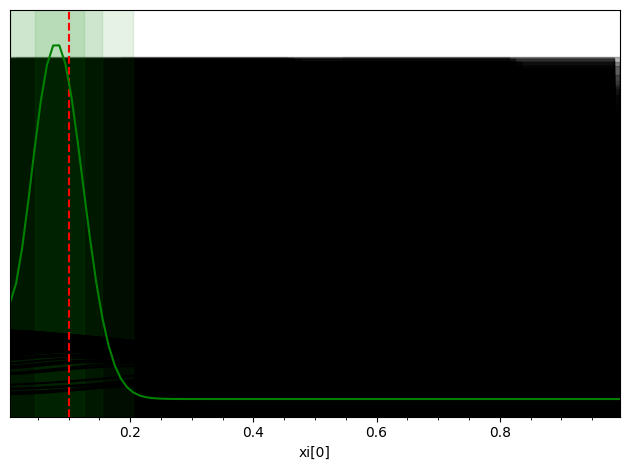

In [29]:
for idx in range(100):
    observation = simulator.sample(conditions={"xi": np.array([0.1])})
    prior_samples = swyft.Samples(
        xi=simulator.transform_samples(np.reshape(np.linspace(0.0, 1.0, 100), (-1, 1)))
    )
    predictions = trainer.infer(
        network, observation, prior_samples.get_dataloader(batch_size=2048)
    )
    if idx == 0:
        lrs_total = predictions
        swyft.plot_posterior(predictions, ["xi[0]"], smooth=2.0);
    else:
        lrs_total.logratios += predictions.logratios
        swyft.plot_posterior(predictions, ["xi[0]"], smooth=2.0, fig=plt.gcf());
plt.axvline(observation["xi"][0], color="red", linestyle="--")
swyft.plot_posterior(lrs_total, ["xi[0]"], smooth=2.0, color='green', fig=plt.gcf());

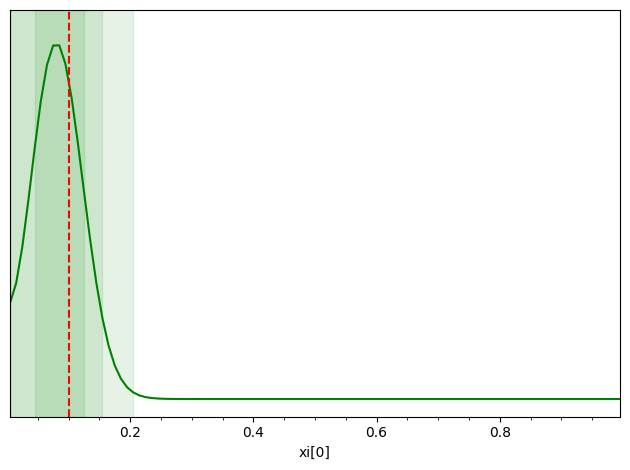

In [31]:
swyft.plot_posterior(lrs_total, ["xi[0]"], smooth=2.0, color='green');
plt.axvline(0.1, color='red', linestyle='--')

## loaded network

In [7]:
network_loaded = Network.load_from_checkpoint('/home/zaldivar/Documents/Androniki/phd/LIGO/LIGO_SGWB/notebooks/lightning_logs/version_0/checkpoints/epoch=16-step=935.ckpt')


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.17it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.54it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.46it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.49it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.22it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.81it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.25it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.15it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.15it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.28it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 109.90it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.82it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.95it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.84it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.78it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.03it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.78it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.71it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.06it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.19it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.97it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.76it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.90it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 251.34it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.53it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.61it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.48it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.92it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.24it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.41it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.38it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.45it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.56it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.20it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 78.54it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.89it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.38it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.65it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.31it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.37it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.92it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.16it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.92it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.90it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.43it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.32it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.59it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.85it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.55it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.90it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.66it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.28it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.45it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.06it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.28it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.52it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.12it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.04it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.06it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.64it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.58it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.75it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.95it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.91it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.25it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.07it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.93it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.48it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.61it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 91.82it/s] 

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.45it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.84it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.86it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 137.98it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.76it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.79it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.12it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.01it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.90it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.98it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.62it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.24it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.17it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.05it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 258.25it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.22it/s] 

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.99it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.08it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.75it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.64it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.90it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.69it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.97it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.26it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 70.40it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.24it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.76it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.83it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.71it/s]


The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.66it/s]


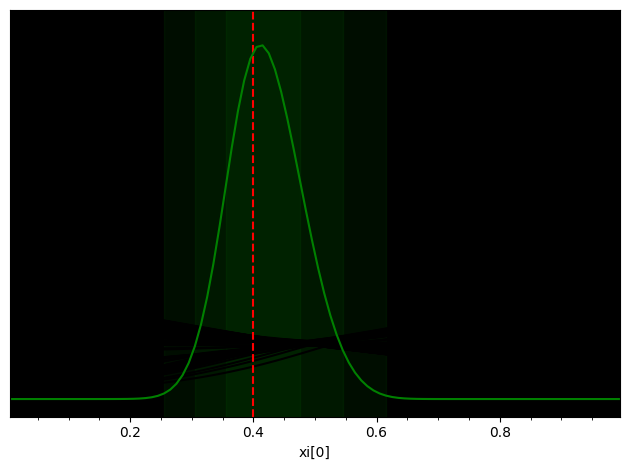

In [12]:
for idx in range(100):
    observation = simulator.sample(conditions={"xi": np.array([0.4])})
    prior_samples = swyft.Samples(
        xi=simulator.transform_samples(np.reshape(np.linspace(0.0, 1.0, 100), (-1, 1)))
    )
    predictions = trainer.infer(
        network_loaded, observation, prior_samples.get_dataloader(batch_size=2048)
    )
    if idx == 0:
        lrs_total = predictions
        swyft.plot_posterior(predictions, ["xi[0]"], smooth=2.0);
    else:
        lrs_total.logratios += predictions.logratios
        swyft.plot_posterior(predictions, ["xi[0]"], smooth=2.0, fig=plt.gcf());
plt.axvline(observation["xi"][0], color="red", linestyle="--")
swyft.plot_posterior(lrs_total, ["xi[0]"], smooth=2.0, color='green', fig=plt.gcf());

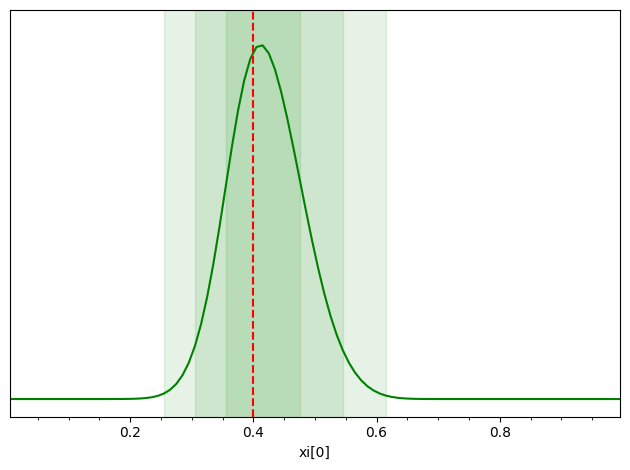

In [14]:
swyft.plot_posterior(lrs_total, ["xi[0]"], smooth=2.0, color='green');
plt.axvline(0.4, color='red', linestyle='--')